In [85]:
#Import all the required libraries. Numpy and Pandas for data analysis and Seaborn and Malplotlib for Visualization.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

#Later on I will import more libraries as required
#VAR PDF helpful: http://www.fsb.miamioh.edu/lij14/672_2014_s7.pdf
#https://scholar.princeton.edu/sites/default/files/mikkelpm/files/lp_var.pdf

In [86]:
#Import the CSV file with annual data on variables from 1990

dataset = pd.read_csv("KSAEcon10SEC.csv", parse_dates=['date'], index_col='date')

Variable	1SD Shock as per Impulse Response																
KSAGDPC	11.6%		1 SD Drop 2020 for VAR? And regression to get another scenario where input into VAR is changed														
MANU	3.7%		1 SD Drop 2020														
CONCOF	0.6%		1 SD Drop 2020														
WGDP	1.3%		**-3% as per IMF in 2020 (more than 1SD for Covid19)														
GUNCERT	36.9%		**Increased by 1SD - has negative relationship														
WTIPrice	24.3%		**Average taken as arbitrary $20 - more than 1SD drop (65% drop in 2019 average price)														
IMPORT	15.3%		**2019 down by 1.5% https://www.ceicdata.com/en/indicator/saudi-arabia/total-imports    whereas 2020 down by 1SD?														
EXPORT	23.4%		**2019 down by 11.73%. ttps://www.ceicdata.com/en/indicator/saudi-arabia/total-exports. 2020 down by 65% only pricing in oil price and not production cuts														
GovConsExDef	12.5%		"**Down 22% Q1 2020 without lockdowns http://www.jadwa.com/en/researchsection/research/economic-research/budget-reports    Down 65% in line with oil price drop scenario taken
**Down 3.5% in 2019 compared to previous year
** Assuming split with defence remains constant as per prev years as data not available"														
GFIXEDCAP	11.3%					2019	175207		2018	165009	https://www.ceicdata.com/en/indicator/saudi-arabia/gross-fixed-capital-formation						
							0.06180269		GFIXEDCAP 2020 dropped by 1SD								
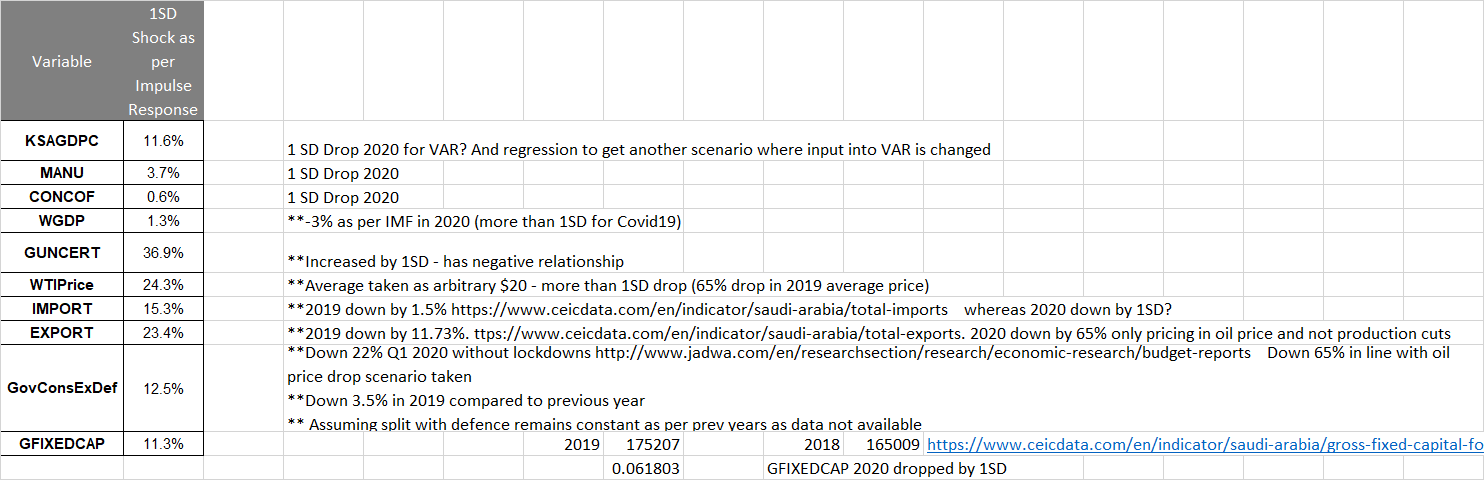

<h2> 1. Perform basic quality checks <h/2>

In [87]:
#Find Basic information about our dataset. Data types, size, column names and null values if any

dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 1990-12-31 to 2020-12-31
Data columns (total 40 columns):
KSAGDPC         31 non-null float64
CRISIS          31 non-null int64
MANU            31 non-null float64
SERV            29 non-null float64
CONCOF          31 non-null float64
BUILD           30 non-null float64
WGDP            31 non-null float64
WUNEMP          29 non-null float64
KSAUNEMP        29 non-null float64
KSAINFLAPCT     30 non-null float64
M2PCT           23 non-null float64
IRPCT           23 non-null float64
GUNCERT         31 non-null float64
NETX            31 non-null float64
WTIPrice        31 non-null float64
OilRentsPUB     31 non-null float64
OilRentsCALC    31 non-null float64
KSAGDPR         30 non-null float64
IMPORT          31 non-null float64
EXPORT          31 non-null float64
OILPRODTBD      30 non-null float64
OILPRODTBY      30 non-null float64
GOVTsLEND       21 non-null float64
GovConsExDef    31 non-null float64
InbTourExp     

In [88]:
#Some variables were shortlisted for being dropped based on previous iterations. There is also rationale behind dropping them.
#SERV moves with MANU (correlations can be plotted. There seemed to be issues with this measure)
#IRPCT follows the US Federal reserve due to maintenance of the PEG. US drives world GDP and WGDP vector is already in the system
#M2PCT is also in proportion to US Fed. US drives world GDP and WGDP vector is already in the system
#KSAINFLAPCT is not required as we are working with current GDP
#KSAUNEMP - this variable cannot be included until we fully understand what is being reported as part of it. For e.g. migrat unemployment
#WUNEMP is related to tourism but in case of KSA tourism, Emerging market UNEMP would be more relevant. Often divergence between Emerging vs. advanced, especially since 2007
#GOVTsLEND This is driven by government spending outlook and M2%
#OILRentsCALC has higher divergence from published numbers. The calc did not account for monthly variation in price
#BUILD excluded residential setor which is a key component. Only commercial and industrial BUILD data available
#NETX was dropped was IMPORt and EXPORT account for it in the system already
#Not enough rows for inboud tourism
# We are working with few rows so KSAGDPC accounts for both KSAGDPR and KSAINFLATPCT

dataset1=dataset.drop(['SERV','M2PCT','KSAINFLAPCT','KSAUNEMP', 'WUNEMP','IRPCT', 'GOVTsLEND', 'OilRentsCALC', 'BUILD', 'OilRentsPUB', 'NETX', 'OILPRODTBY', 'OILPRODTBD', 'KSAGDPR','InbTourExp', 'HCGVA', 'WTGVA', 'UTGVA', 'RTGVA', 'RHGVA'], axis=1)

In [89]:
#After dropping variables, we work with dataset1

dataset1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 1990-12-31 to 2020-12-31
Data columns (total 20 columns):
KSAGDPC         31 non-null float64
CRISIS          31 non-null int64
MANU            31 non-null float64
CONCOF          31 non-null float64
WGDP            31 non-null float64
GUNCERT         31 non-null float64
WTIPrice        31 non-null float64
IMPORT          31 non-null float64
EXPORT          31 non-null float64
GovConsExDef    31 non-null float64
GFIXEDCAP       31 non-null float64
MANUGVA         30 non-null float64
PAGVA           30 non-null float64
REGVA           30 non-null float64
PSGVA           30 non-null float64
AGRIGVA         30 non-null float64
CONSGVA         30 non-null float64
EDUGVA          30 non-null float64
FSGVA           30 non-null float64
Oggva           30 non-null float64
dtypes: float64(19), int64(1)
memory usage: 5.1 KB


In [90]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 1990-12-31 to 2020-12-31
Data columns (total 40 columns):
KSAGDPC         31 non-null float64
CRISIS          31 non-null int64
MANU            31 non-null float64
SERV            29 non-null float64
CONCOF          31 non-null float64
BUILD           30 non-null float64
WGDP            31 non-null float64
WUNEMP          29 non-null float64
KSAUNEMP        29 non-null float64
KSAINFLAPCT     30 non-null float64
M2PCT           23 non-null float64
IRPCT           23 non-null float64
GUNCERT         31 non-null float64
NETX            31 non-null float64
WTIPrice        31 non-null float64
OilRentsPUB     31 non-null float64
OilRentsCALC    31 non-null float64
KSAGDPR         30 non-null float64
IMPORT          31 non-null float64
EXPORT          31 non-null float64
OILPRODTBD      30 non-null float64
OILPRODTBY      30 non-null float64
GOVTsLEND       21 non-null float64
GovConsExDef    31 non-null float64
InbTourExp     

In [91]:
#Data ranks below average on completeness. Firstly, annual data does not capture the quarterly dynamics 
#that are key to forecast GDP in the short run. Additionally some variables were either unavailable or only
#available for purchase.
#finally, some variables might have to be dropped due to too few rows


In [92]:
#Next data quality check is for null values
dataset1.isnull().any()

KSAGDPC         False
CRISIS          False
MANU            False
CONCOF          False
WGDP            False
GUNCERT         False
WTIPrice        False
IMPORT          False
EXPORT          False
GovConsExDef    False
GFIXEDCAP       False
MANUGVA          True
PAGVA            True
REGVA            True
PSGVA            True
AGRIGVA          True
CONSGVA          True
EDUGVA           True
FSGVA            True
Oggva            True
dtype: bool

In [93]:
dataset1.head(5)

KSAGDPC  CRISIS   MANU      CONCOF         WGDP    GUNCERT  \
date                                                                        
1990-12-31  440.525368       1  85.07  100.636467  7171.438438  12334.384   
1991-12-31  495.176141       1  82.85  100.108033  7158.367658   8057.454   
1992-12-31  513.394098       1  86.18   99.632517  7172.132639  10183.929   
1993-12-31  497.964791       1  88.70   98.991400  7169.133917  12960.895   
1994-12-31  506.229950       1  92.00  100.183942  7272.894902  10129.384   

            WTIPrice        IMPORT        EXPORT  GovConsExDef     GFIXEDCAP  \
date                                                                           
1990-12-31     24.53  3.690441e+10  4.744593e+10       82234.0  8.325064e+10   
1991-12-31     21.54  4.811722e+10  5.065260e+10      109933.0  1.000000e+11   
1992-12-31     20.58  4.933138e+10  5.361068e+10       96333.0  1.040000e+11   
1993-12-31     18.43  4.448331e+10  4.567824e+10       79680.0  1.090000e+11   
1994-12-31     17.20  3.524059e+10  4.596075e+10       77049.0  9.300217e+10   

            MANUGVA   PAGVA  REGVA   PSGVA  AGRIGVA  CONSGVA  EDUGVA  FSGVA  \
date                                                                          
1990-12-31    85.07   95.82  73.27  214.20    36.75    49.08   35.71  24.35   
1991-12-31    82.85   98.31  73.80  219.75    37.81    50.28   36.63  22.79   
1992-12-31    86.18  103.99  73.04  232.45    40.09    49.42   38.75  25.01   
1993-12-31    88.70  105.61  70.10  236.07    41.49    50.62   39.35  25.12   
1994-12-31    92.00  106.43  68.00  237.90    40.54    53.22   39.66  25.40   

             Oggva  
date                
1990-12-31  363.56  
1991-12-31  458.05  
1992-12-31  472.00  
1993-12-31  455.65  
1994-12-31  456.96

In [94]:
dataset1.tail(5)

KSAGDPC  CRISIS       MANU      CONCOF         WGDP  \
date                                                                  
2016-12-31  2418.508280       1  321.17000  100.355375  10473.74581   
2017-12-31  2582.198416       1  325.34000  100.581433  10685.56418   
2018-12-31  2949.456868       1  332.16000  100.627600  10891.00147   
2019-12-31  2973.625643       1  337.57000  100.007208  11206.84051   
2020-12-31  2628.685068       2  325.07991   99.407165  11061.15159   

                GUNCERT  WTIPrice        IMPORT        EXPORT  GovConsExDef  \
date                                                                          
2016-12-31  25888.22000     43.29  1.980000e+11  2.010000e+11    497976.000   
2017-12-31  22786.65800     50.80  2.020000e+11  2.400000e+11    502908.000   
2018-12-31  23607.30000     65.23  2.100000e+11  3.140000e+11    576996.000   
2019-12-31  40648.57500     56.99  2.070000e+11  2.770000e+11    556801.140   
2020-12-31  55647.89918     20.00  1.750000e+11  9.700873e+10    194880.399   

               GFIXEDCAP  MANUGVA   PAGVA   REGVA   PSGVA  AGRIGVA  CONSGVA  \
date                                                                          
2016-12-31  6.320000e+11   321.17  212.87  187.03  475.83    64.67   157.79   
2017-12-31  6.320000e+11   325.34  213.52  197.70  477.28    65.00   152.66   
2018-12-31  6.130000e+11   332.16  219.86  202.77  491.46    65.21   147.34   
2019-12-31  6.500000e+11   337.57  222.10  212.89  504.11    65.85   152.60   
2020-12-31  5.770000e+11      NaN     NaN     NaN     NaN      NaN      NaN   

            EDUGVA   FSGVA   Oggva  
date                                
2016-12-31   81.00   91.45  606.18  
2017-12-31   78.01   98.44  584.08  
2018-12-31   80.33  102.25  605.51  
2019-12-31   83.41  107.35  578.87  
2020-12-31     NaN     NaN     NaN

In [95]:
#Drop missing values. This gives us dataset2

dataset2=dataset1.dropna()

In [96]:
dataset2.tail(5)

KSAGDPC  CRISIS    MANU      CONCOF         WGDP    GUNCERT  \
date                                                                          
2015-12-31  2453.512136       2  311.21  100.321125  10328.91590  23749.328   
2016-12-31  2418.508280       1  321.17  100.355375  10473.74581  25888.220   
2017-12-31  2582.198416       1  325.34  100.581433  10685.56418  22786.658   
2018-12-31  2949.456868       1  332.16  100.627600  10891.00147  23607.300   
2019-12-31  2973.625643       1  337.57  100.007208  11206.84051  40648.575   

            WTIPrice        IMPORT        EXPORT  GovConsExDef     GFIXEDCAP  \
date                                                                           
2015-12-31     48.66  2.540000e+11  2.180000e+11     576504.00  7.320000e+11   
2016-12-31     43.29  1.980000e+11  2.010000e+11     497976.00  6.320000e+11   
2017-12-31     50.80  2.020000e+11  2.400000e+11     502908.00  6.320000e+11   
2018-12-31     65.23  2.100000e+11  3.140000e+11     576996.00  6.130000e+11   
2019-12-31     56.99  2.070000e+11  2.770000e+11     556801.14  6.500000e+11   

            MANUGVA   PAGVA   REGVA   PSGVA  AGRIGVA  CONSGVA  EDUGVA   FSGVA  \
date                                                                            
2015-12-31   311.21  212.53  181.54  475.07    64.27   162.97   80.28   88.62   
2016-12-31   321.17  212.87  187.03  475.83    64.67   157.79   81.00   91.45   
2017-12-31   325.34  213.52  197.70  477.28    65.00   152.66   78.01   98.44   
2018-12-31   332.16  219.86  202.77  491.46    65.21   147.34   80.33  102.25   
2019-12-31   337.57  222.10  212.89  504.11    65.85   152.60   83.41  107.35   

             Oggva  
date                
2015-12-31  589.29  
2016-12-31  606.18  
2017-12-31  584.08  
2018-12-31  605.51  
2019-12-31  578.87

In [97]:
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 1990-12-31 to 2019-12-31
Data columns (total 20 columns):
KSAGDPC         30 non-null float64
CRISIS          30 non-null int64
MANU            30 non-null float64
CONCOF          30 non-null float64
WGDP            30 non-null float64
GUNCERT         30 non-null float64
WTIPrice        30 non-null float64
IMPORT          30 non-null float64
EXPORT          30 non-null float64
GovConsExDef    30 non-null float64
GFIXEDCAP       30 non-null float64
MANUGVA         30 non-null float64
PAGVA           30 non-null float64
REGVA           30 non-null float64
PSGVA           30 non-null float64
AGRIGVA         30 non-null float64
CONSGVA         30 non-null float64
EDUGVA          30 non-null float64
FSGVA           30 non-null float64
Oggva           30 non-null float64
dtypes: float64(19), int64(1)
memory usage: 4.9 KB


<h2> 2. Perform basic exploratory analysis and transformations <h/2>

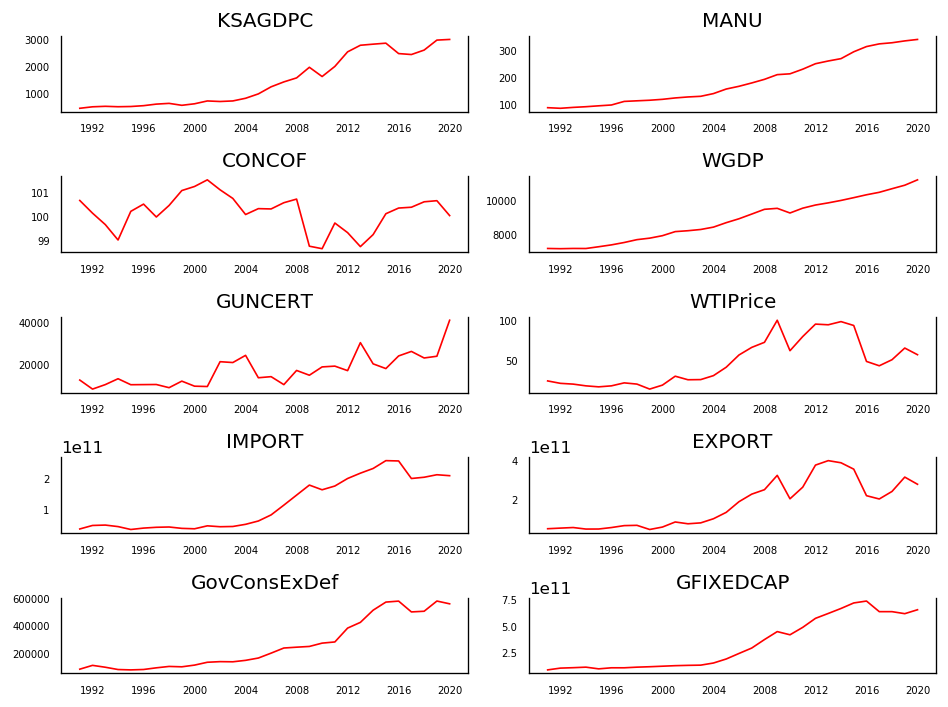

In [197]:
# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(8,6))
for i, ax in enumerate(axes.flatten()):
    data = dataset2[dataset2.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(dataset2.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout();


In [98]:
#Let's also visualize the percntage change. dataset4 is the new dataset after incorporating yoy change

dataset4 = dataset2.pct_change()

In [99]:
dataset4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 1990-12-31 to 2019-12-31
Data columns (total 20 columns):
KSAGDPC         29 non-null float64
CRISIS          29 non-null float64
MANU            29 non-null float64
CONCOF          29 non-null float64
WGDP            29 non-null float64
GUNCERT         29 non-null float64
WTIPrice        29 non-null float64
IMPORT          29 non-null float64
EXPORT          29 non-null float64
GovConsExDef    29 non-null float64
GFIXEDCAP       29 non-null float64
MANUGVA         29 non-null float64
PAGVA           29 non-null float64
REGVA           29 non-null float64
PSGVA           29 non-null float64
AGRIGVA         29 non-null float64
CONSGVA         29 non-null float64
EDUGVA          29 non-null float64
FSGVA           29 non-null float64
Oggva           29 non-null float64
dtypes: float64(20)
memory usage: 4.9 KB


In [100]:
#Drop NA (if any) due to PCT change. Gives us dataset5

dataset5=dataset4.dropna()

In [101]:
dataset5.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29 entries, 1991-12-31 to 2019-12-31
Data columns (total 20 columns):
KSAGDPC         29 non-null float64
CRISIS          29 non-null float64
MANU            29 non-null float64
CONCOF          29 non-null float64
WGDP            29 non-null float64
GUNCERT         29 non-null float64
WTIPrice        29 non-null float64
IMPORT          29 non-null float64
EXPORT          29 non-null float64
GovConsExDef    29 non-null float64
GFIXEDCAP       29 non-null float64
MANUGVA         29 non-null float64
PAGVA           29 non-null float64
REGVA           29 non-null float64
PSGVA           29 non-null float64
AGRIGVA         29 non-null float64
CONSGVA         29 non-null float64
EDUGVA          29 non-null float64
FSGVA           29 non-null float64
Oggva           29 non-null float64
dtypes: float64(20)
memory usage: 4.8 KB


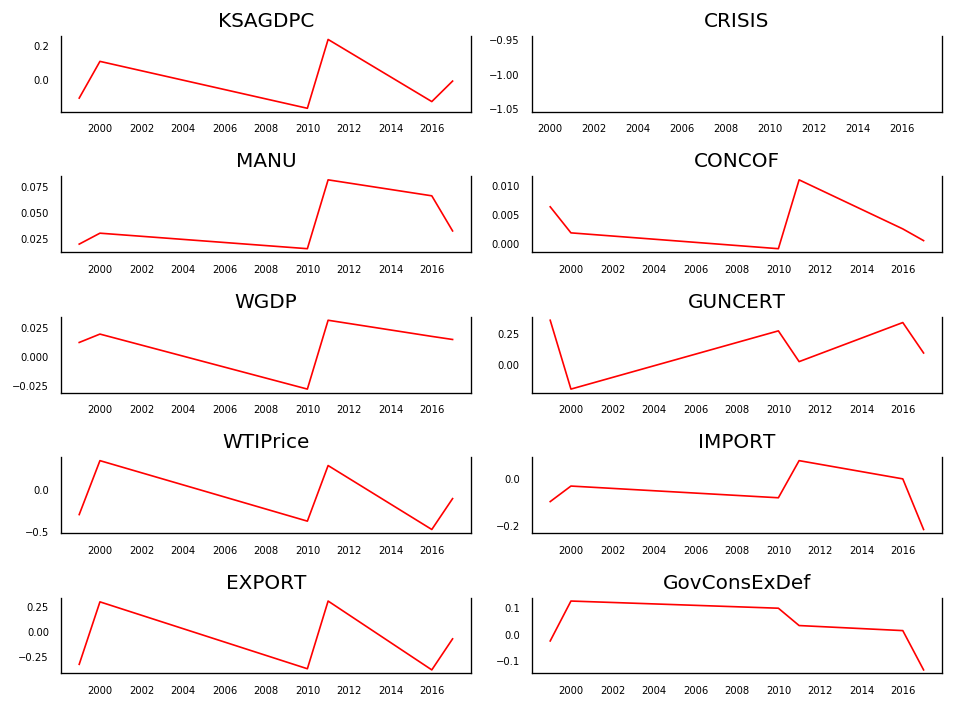

In [136]:
# Plot dataset 5 to visualize the variables
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(8,6))
for i, ax in enumerate(axes.flatten()):
    data = dataset5[dataset5.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(dataset5.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout();


In [76]:
#Distributions and correlations on dataset5 i.e. pct change

sns.pairplot(dataset5)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000002523A395EA0> (for post_execute):


KeyboardInterrupt: 

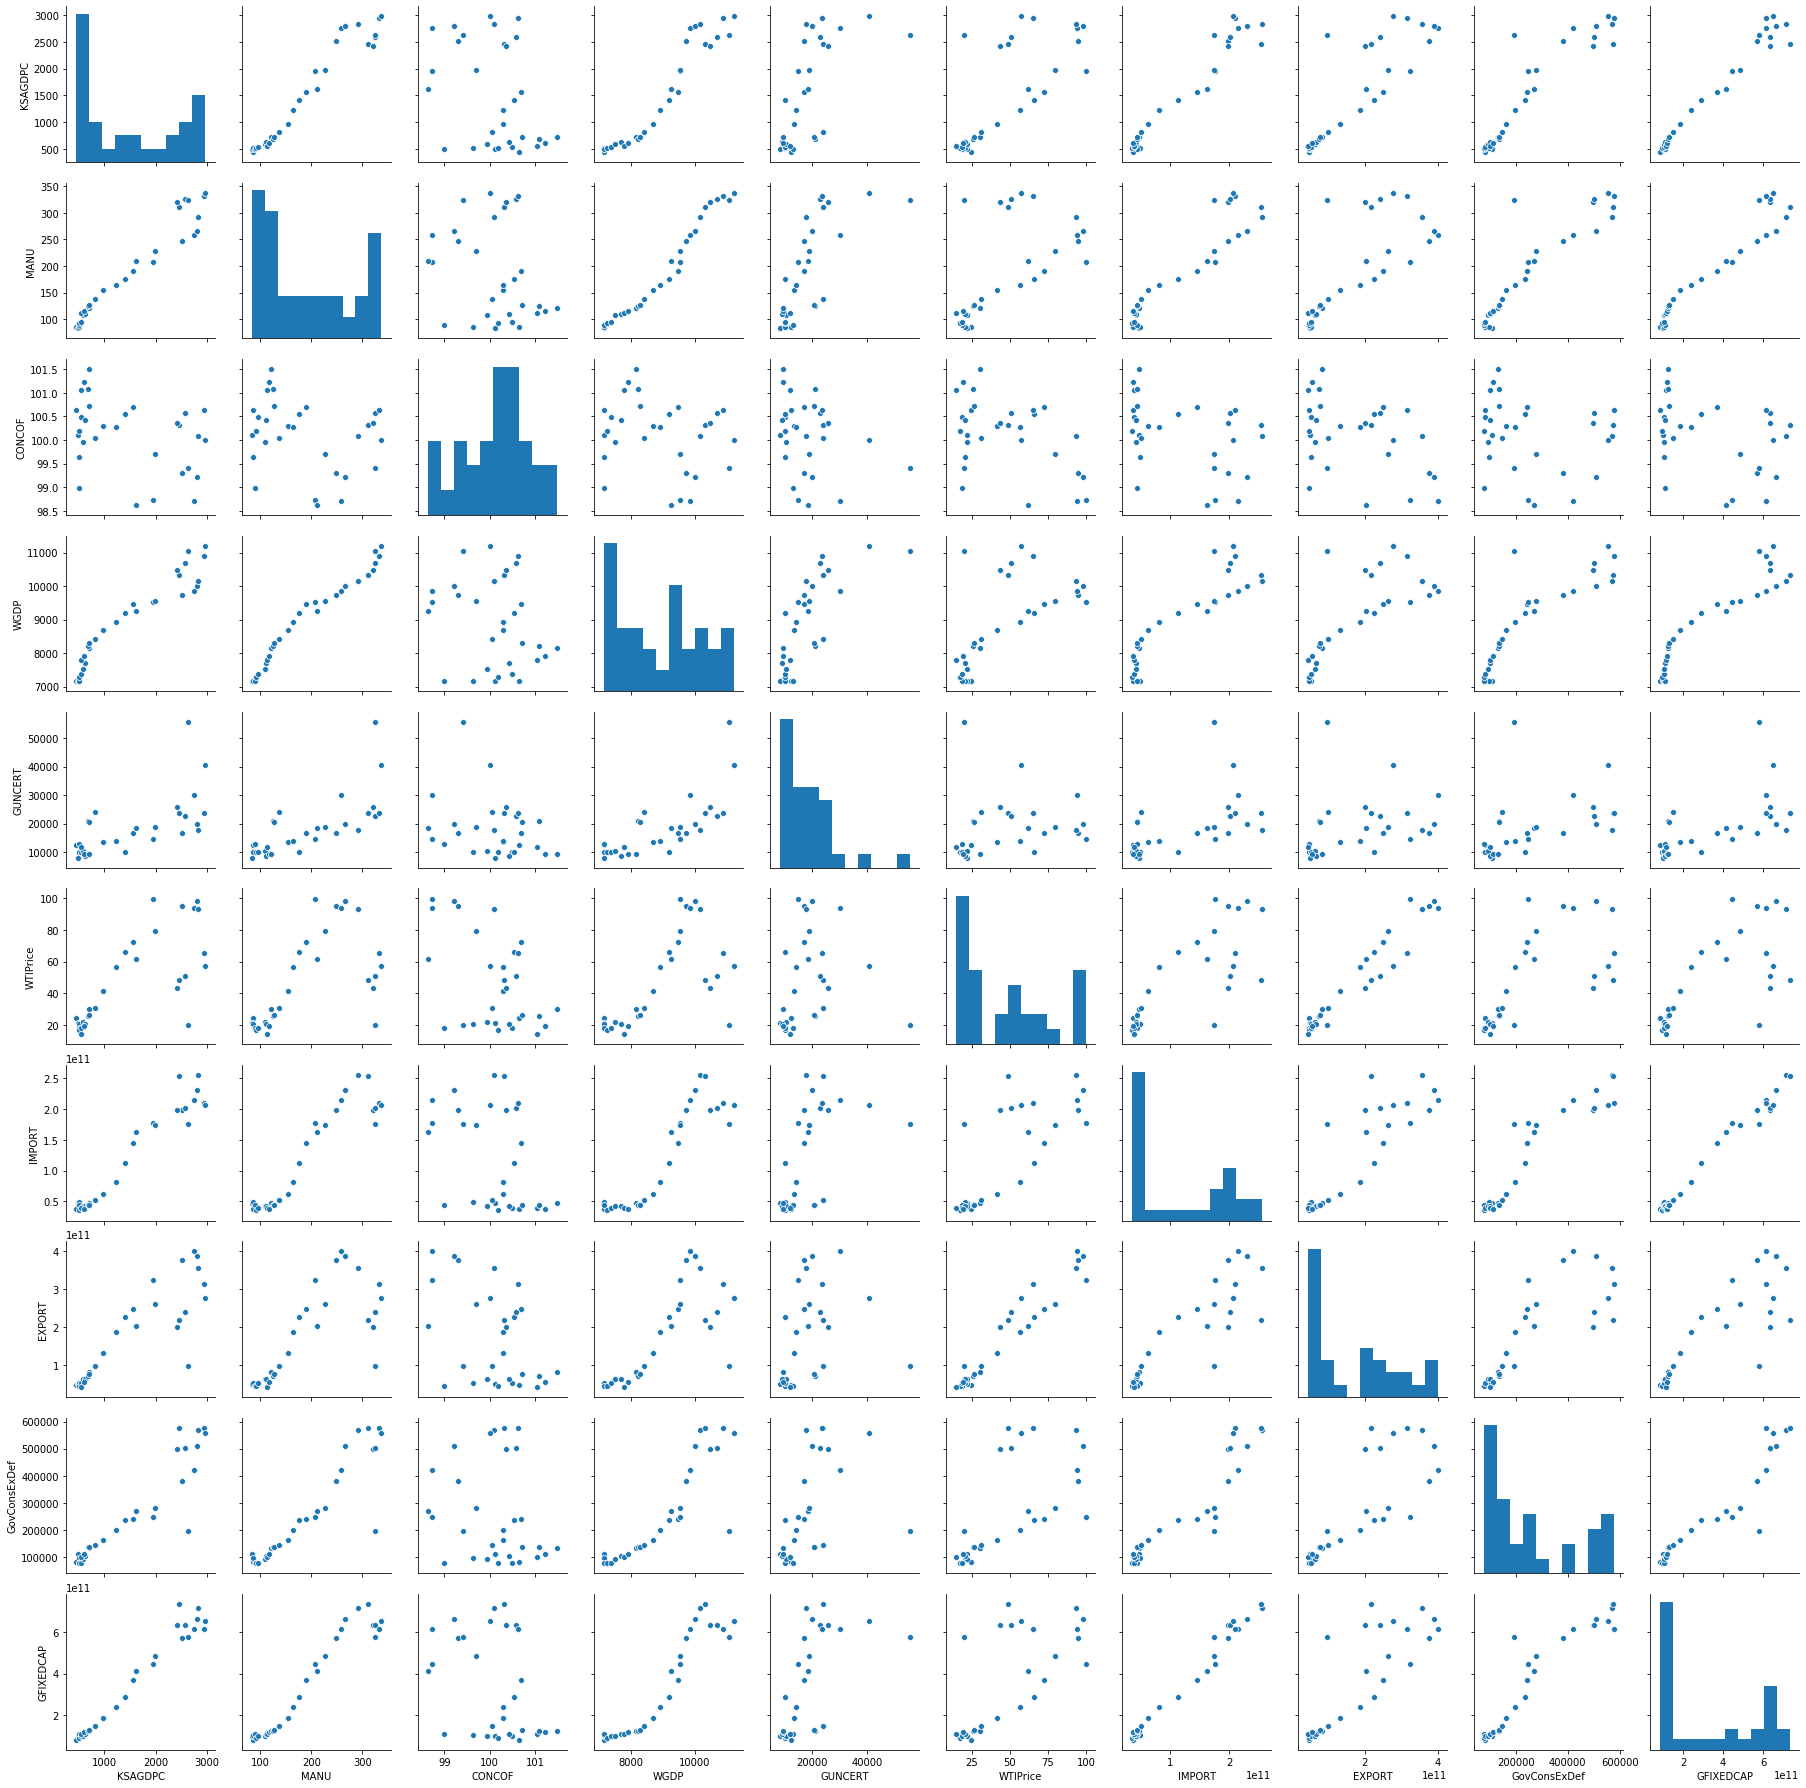

In [20]:
#Distributions and correlations on dataset5 i.e. without pct change

sns.pairplot(dataset2)

In [102]:
#dataset2 is the original dataset with dropped variables

dataset2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 1990-12-31 to 2019-12-31
Data columns (total 20 columns):
KSAGDPC         30 non-null float64
CRISIS          30 non-null int64
MANU            30 non-null float64
CONCOF          30 non-null float64
WGDP            30 non-null float64
GUNCERT         30 non-null float64
WTIPrice        30 non-null float64
IMPORT          30 non-null float64
EXPORT          30 non-null float64
GovConsExDef    30 non-null float64
GFIXEDCAP       30 non-null float64
MANUGVA         30 non-null float64
PAGVA           30 non-null float64
REGVA           30 non-null float64
PSGVA           30 non-null float64
AGRIGVA         30 non-null float64
CONSGVA         30 non-null float64
EDUGVA          30 non-null float64
FSGVA           30 non-null float64
Oggva           30 non-null float64
dtypes: float64(19), int64(1)
memory usage: 4.9 KB


In [103]:
#further calcs were done dataset6 which have been removed from the script
dataset6 = dataset2

In [104]:
dataset6.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 1990-12-31 to 2019-12-31
Data columns (total 20 columns):
KSAGDPC         30 non-null float64
CRISIS          30 non-null int64
MANU            30 non-null float64
CONCOF          30 non-null float64
WGDP            30 non-null float64
GUNCERT         30 non-null float64
WTIPrice        30 non-null float64
IMPORT          30 non-null float64
EXPORT          30 non-null float64
GovConsExDef    30 non-null float64
GFIXEDCAP       30 non-null float64
MANUGVA         30 non-null float64
PAGVA           30 non-null float64
REGVA           30 non-null float64
PSGVA           30 non-null float64
AGRIGVA         30 non-null float64
CONSGVA         30 non-null float64
EDUGVA          30 non-null float64
FSGVA           30 non-null float64
Oggva           30 non-null float64
dtypes: float64(19), int64(1)
memory usage: 4.9 KB


In [105]:
dataset6.tail(5)

KSAGDPC  CRISIS    MANU      CONCOF         WGDP    GUNCERT  \
date                                                                          
2015-12-31  2453.512136       2  311.21  100.321125  10328.91590  23749.328   
2016-12-31  2418.508280       1  321.17  100.355375  10473.74581  25888.220   
2017-12-31  2582.198416       1  325.34  100.581433  10685.56418  22786.658   
2018-12-31  2949.456868       1  332.16  100.627600  10891.00147  23607.300   
2019-12-31  2973.625643       1  337.57  100.007208  11206.84051  40648.575   

            WTIPrice        IMPORT        EXPORT  GovConsExDef     GFIXEDCAP  \
date                                                                           
2015-12-31     48.66  2.540000e+11  2.180000e+11     576504.00  7.320000e+11   
2016-12-31     43.29  1.980000e+11  2.010000e+11     497976.00  6.320000e+11   
2017-12-31     50.80  2.020000e+11  2.400000e+11     502908.00  6.320000e+11   
2018-12-31     65.23  2.100000e+11  3.140000e+11     576996.00  6.130000e+11   
2019-12-31     56.99  2.070000e+11  2.770000e+11     556801.14  6.500000e+11   

            MANUGVA   PAGVA   REGVA   PSGVA  AGRIGVA  CONSGVA  EDUGVA   FSGVA  \
date                                                                            
2015-12-31   311.21  212.53  181.54  475.07    64.27   162.97   80.28   88.62   
2016-12-31   321.17  212.87  187.03  475.83    64.67   157.79   81.00   91.45   
2017-12-31   325.34  213.52  197.70  477.28    65.00   152.66   78.01   98.44   
2018-12-31   332.16  219.86  202.77  491.46    65.21   147.34   80.33  102.25   
2019-12-31   337.57  222.10  212.89  504.11    65.85   152.60   83.41  107.35   

             Oggva  
date                
2015-12-31  589.29  
2016-12-31  606.18  
2017-12-31  584.08  
2018-12-31  605.51  
2019-12-31  578.87

<h2> 3. Testing for Stationarity <h/2>

We will now conduct unit root tests to check if the series is stationary

In [106]:
def adjust(val, length= 6): return str(val).ljust(length)

In [107]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    


In [108]:
# ADF Test on each column. Augmented Dickey Fuller tests for whether the series is difference stationary.
#Late we discover that the series is difference stationary

for name, column in dataset6.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "KSAGDPC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.1879
 No. Lags Chosen       = 0
 Critical value 1%     = -3.679
 Critical value 5%     = -2.968
 Critical value 10%    = -2.623
 => P-Value = 0.9716. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "CRISIS" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.8347
 No. Lags Chosen       = 0
 Critical value 1%     = -3.679
 Critical value 5%     = -2.968
 Critical value 10%    = -2.623
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "MANU" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 

In [109]:
# 1st difference
dataset6_differenced = dataset6.diff().dropna()

In [110]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in dataset6_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "KSAGDPC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.5753
 No. Lags Chosen       = 9
 Critical value 1%     = -3.833
 Critical value 5%     = -3.031
 Critical value 10%    = -2.656
 => P-Value = 0.0982. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "CRISIS" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.5621
 No. Lags Chosen       = 9
 Critical value 1%     = -3.833
 Critical value 5%     = -3.031
 Critical value 10%    = -2.656
 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "MANU" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationar

In [111]:
# Second Differencing
dataset6_differenced1 = dataset6_differenced.diff().dropna()

In [112]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in dataset6_differenced1.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "KSAGDPC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.0722
 No. Lags Chosen       = 9
 Critical value 1%     = -3.859
 Critical value 5%     = -3.042
 Critical value 10%    = -2.661
 => P-Value = 0.9641. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "CRISIS" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.5996
 No. Lags Chosen       = 9
 Critical value 1%     = -3.859
 Critical value 5%     = -3.042
 Critical value 10%    = -2.661
 => P-Value = 0.0931. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "MANU" 
    -----------------------------------------------
 Null Hypothesis: Data has uni

In [113]:
# Third Differencing
dataset6_differenced2 = dataset6_differenced1.diff().dropna()

In [114]:
# ADF Test on each column of third Differences Dataframe
for name, column in dataset6_differenced2.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "KSAGDPC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.5892
 No. Lags Chosen       = 8
 Critical value 1%     = -3.859
 Critical value 5%     = -3.042
 Critical value 10%    = -2.661
 => P-Value = 0.8734. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "CRISIS" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.6171
 No. Lags Chosen       = 8
 Critical value 1%     = -3.859
 Critical value 5%     = -3.042
 Critical value 10%    = -2.661
 => P-Value = 0.4743. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "MANU" 
    -----------------------------------------------
 Null Hypothesis: Data has un

In [115]:
# Fourth Differencing
dataset6_differenced3 = dataset6_differenced2.diff().dropna()

In [116]:
# ADF Test on each column of fourth Differences Dataframe
for name, column in dataset6_differenced3.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "KSAGDPC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.4177
 No. Lags Chosen       = 7
 Critical value 1%     = -3.859
 Critical value 5%     = -3.042
 Critical value 10%    = -2.661
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CRISIS" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.7115
 No. Lags Chosen       = 7
 Critical value 1%     = -3.859
 Critical value 5%     = -3.042
 Critical value 10%    = -2.661
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "MANU" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 

In [117]:
# fifth Differencing
dataset6_differenced4 = dataset6_differenced3.diff().dropna()

In [118]:
# ADF Test on each column of fifth Differences Dataframe
for name, column in dataset6_differenced4.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "KSAGDPC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.0891
 No. Lags Chosen       = 8
 Critical value 1%     = -3.924
 Critical value 5%     = -3.068
 Critical value 10%    = -2.674
 => P-Value = 0.0274. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CRISIS" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.8873
 No. Lags Chosen       = 8
 Critical value 1%     = -3.924
 Critical value 5%     = -3.068
 Critical value 10%    = -2.674
 => P-Value = 0.0021. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "MANU" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level

In [119]:
# sixth Differencing
dataset6_differenced5 = dataset6_differenced4.diff().dropna()

In [120]:
# ADF Test on each column of 6th Differences Dataframe
for name, column in dataset6_differenced5.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "KSAGDPC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.5763
 No. Lags Chosen       = 8
 Critical value 1%     = -3.964
 Critical value 5%     = -3.085
 Critical value 10%    = -2.682
 => P-Value = 0.0062. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CRISIS" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1002
 No. Lags Chosen       = 9
 Critical value 1%     = -4.012
 Critical value 5%     = -3.104
 Critical value 10%    = -2.691
 => P-Value = 0.0265. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "MANU" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level

Since our series is not proving to be stationary despite taking differences, we take logs and subsequently differences of logs

In [121]:
#Taking Logs on original series

#Taking logs. Added +1 in order to take care of zero values in any column. Log of zero would return an error otherwise
Ldataset6 = np.log(dataset6 + 1)

In [122]:
# ADF Test on each column
for name, column in Ldataset6.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "KSAGDPC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.4276
 No. Lags Chosen       = 0
 Critical value 1%     = -3.679
 Critical value 5%     = -2.968
 Critical value 10%    = -2.623
 => P-Value = 0.9054. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "CRISIS" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.8347
 No. Lags Chosen       = 0
 Critical value 1%     = -3.679
 Critical value 5%     = -2.968
 Critical value 10%    = -2.623
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "MANU" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.


In [165]:
#Taking differences of logs
DLdataset6 = Ldataset6.diff().dropna()

In [124]:
DLdataset6.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29 entries, 1991-12-31 to 2019-12-31
Data columns (total 20 columns):
KSAGDPC         29 non-null float64
CRISIS          29 non-null float64
MANU            29 non-null float64
CONCOF          29 non-null float64
WGDP            29 non-null float64
GUNCERT         29 non-null float64
WTIPrice        29 non-null float64
IMPORT          29 non-null float64
EXPORT          29 non-null float64
GovConsExDef    29 non-null float64
GFIXEDCAP       29 non-null float64
MANUGVA         29 non-null float64
PAGVA           29 non-null float64
REGVA           29 non-null float64
PSGVA           29 non-null float64
AGRIGVA         29 non-null float64
CONSGVA         29 non-null float64
EDUGVA          29 non-null float64
FSGVA           29 non-null float64
Oggva           29 non-null float64
dtypes: float64(20)
memory usage: 4.8 KB


In [125]:
DLdataset6.tail(2)

KSAGDPC  CRISIS      MANU    CONCOF      WGDP   GUNCERT  \
date                                                                   
2018-12-31  0.132932     0.0  0.020683  0.000454  0.019041  0.035379   
2019-12-31  0.008158     0.0  0.016108 -0.006123  0.028585  0.543390   

            WTIPrice    IMPORT    EXPORT  GovConsExDef  GFIXEDCAP   MANUGVA  \
date                                                                          
2018-12-31  0.245743  0.038840  0.268754      0.137428  -0.030524  0.020683   
2019-12-31 -0.132863 -0.014389 -0.125375     -0.035627   0.058607  0.016108   

               PAGVA     REGVA     PSGVA   AGRIGVA   CONSGVA    EDUGVA  \
date                                                                     
2018-12-31  0.029126  0.025196  0.029217  0.003177 -0.035235  0.028941   
2019-12-31  0.010091  0.048470  0.025363  0.009620  0.034845  0.037171   

               FSGVA     Oggva  
date                            
2018-12-31  0.037599  0.035973  
2019-12-31  0.048213 -0.044917

In [126]:
# ADF Test on each column with differenced log
for name, column in DLdataset6.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "KSAGDPC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.7385
 No. Lags Chosen       = 0
 Critical value 1%     = -3.689
 Critical value 5%     = -2.972
 Critical value 10%    = -2.625
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CRISIS" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.5621
 No. Lags Chosen       = 9
 Critical value 1%     = -3.833
 Critical value 5%     = -3.031
 Critical value 10%    = -2.656
 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "MANU" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level

In [127]:
#So taking differences of logs has now made our series stationary 

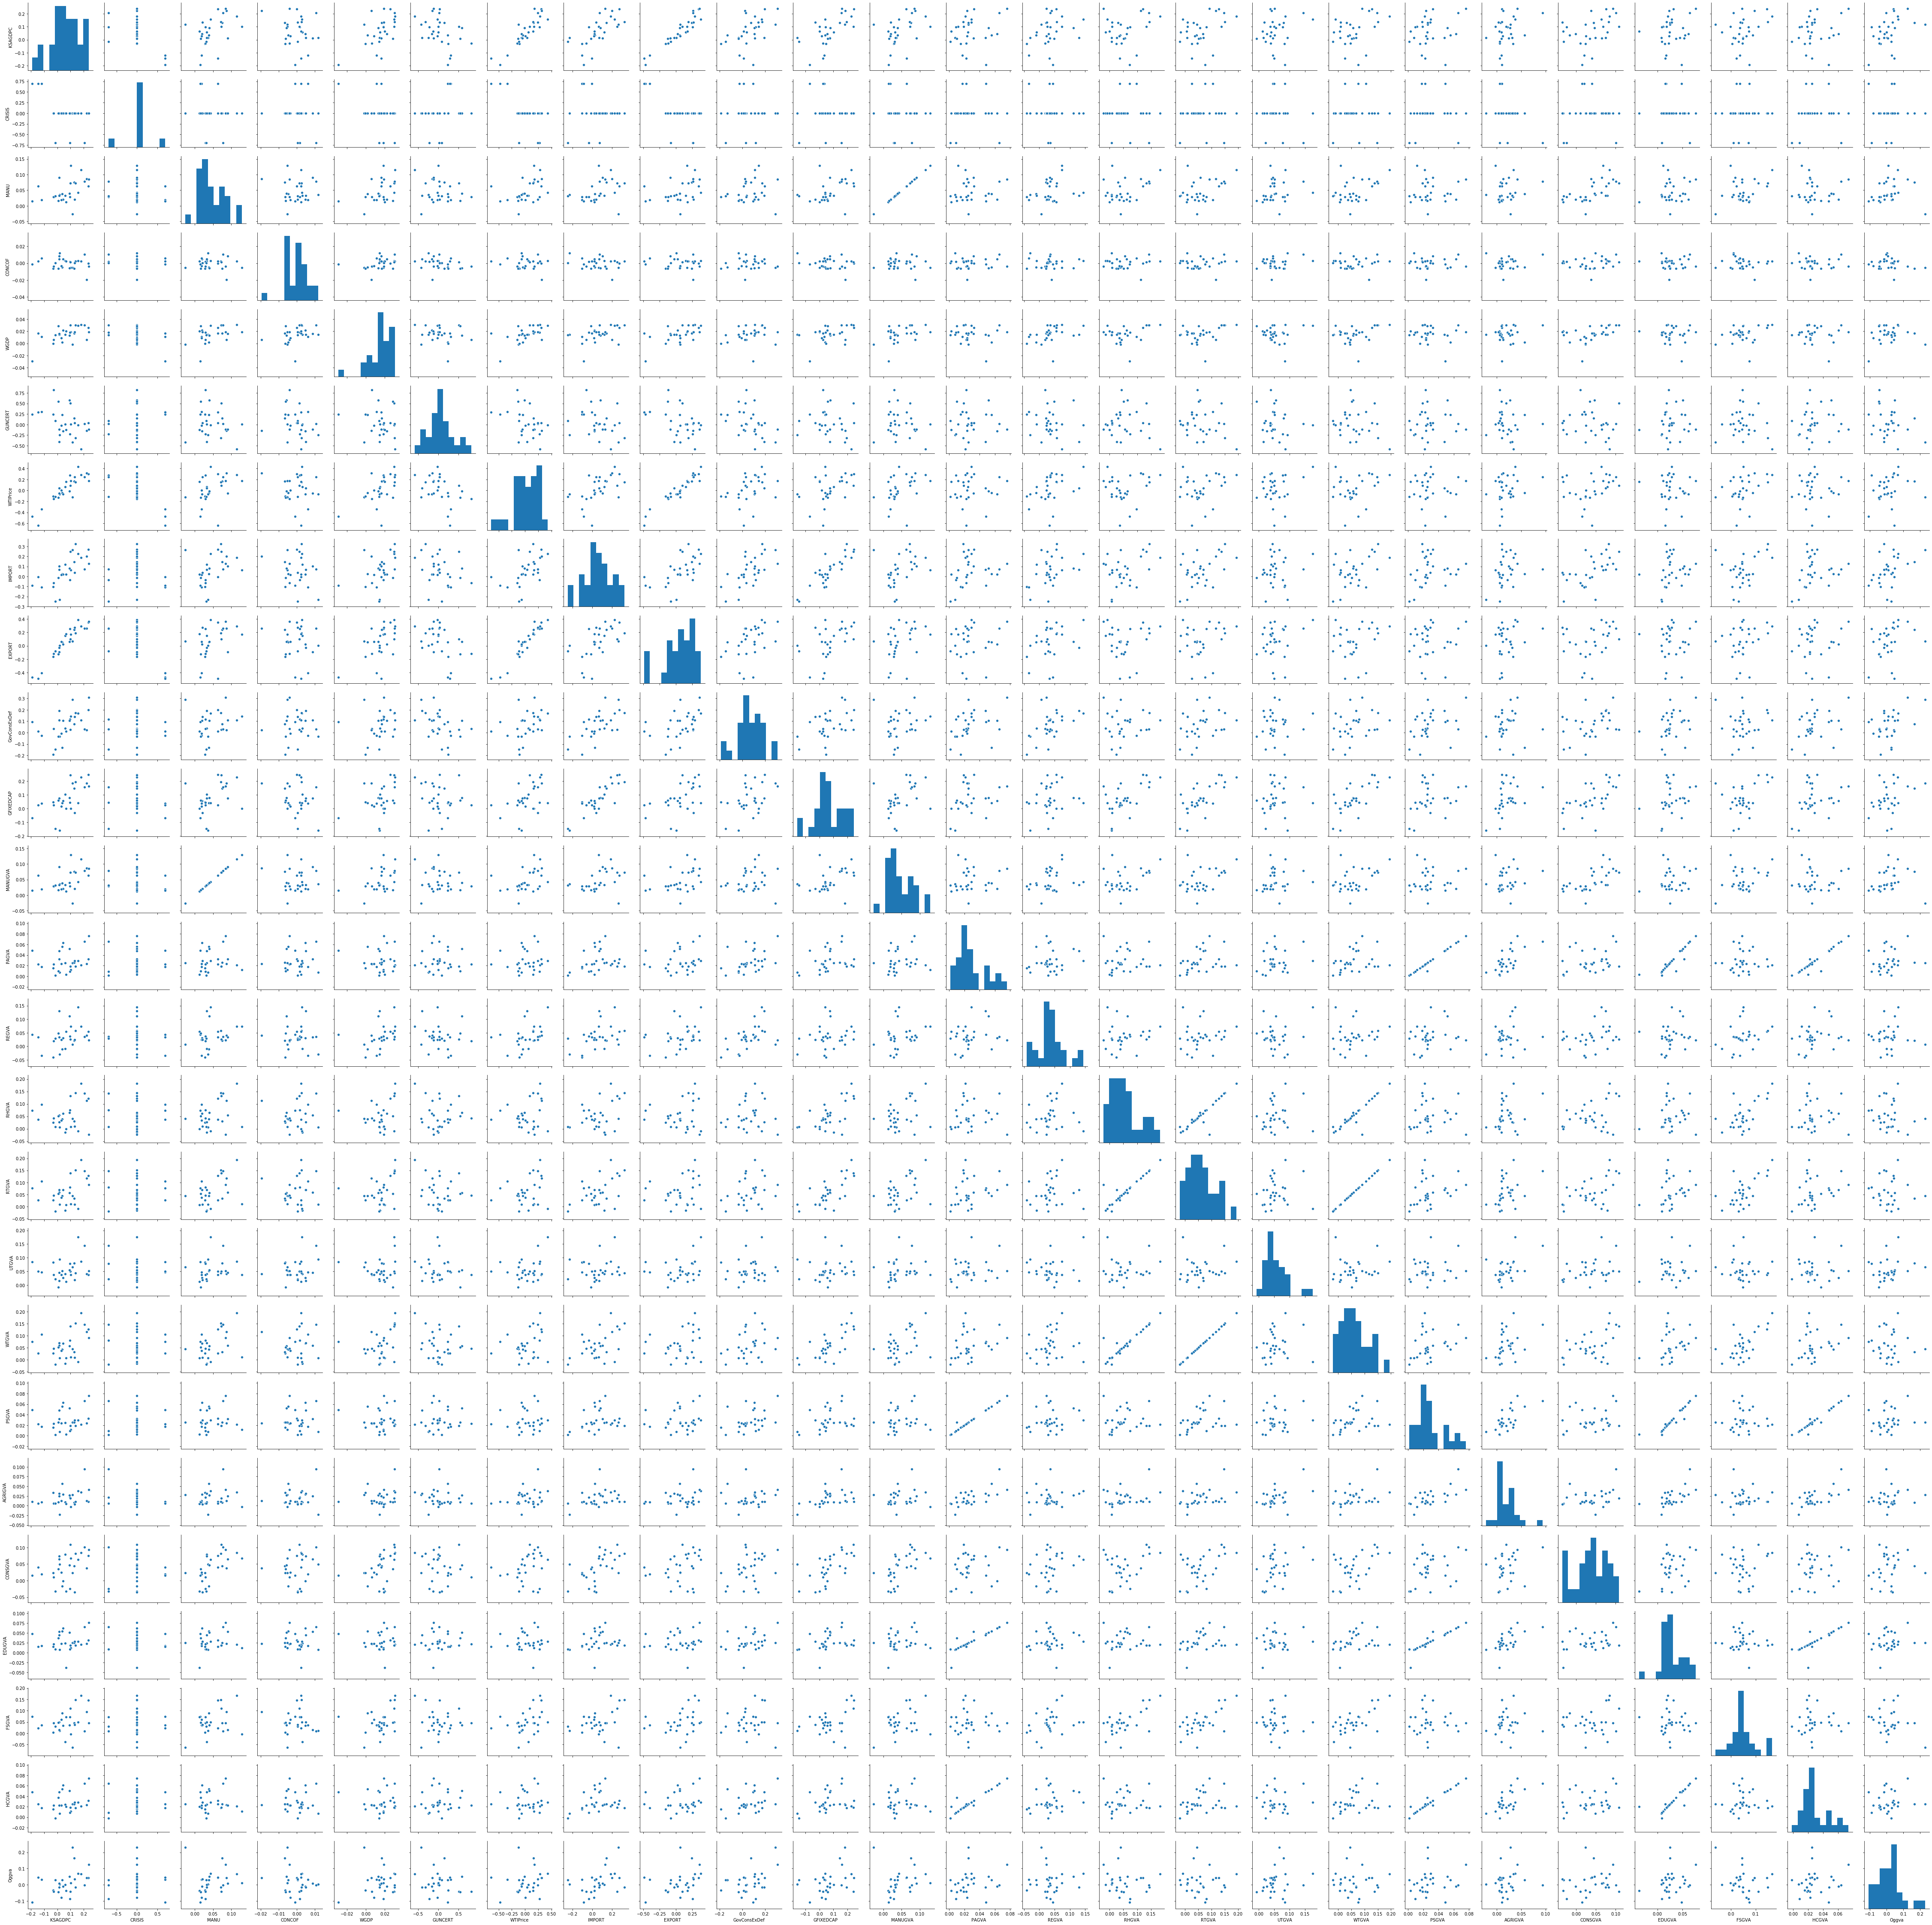

In [45]:
#Plotting the log differenced series to understand correl and distribution

sns.pairplot(DLdataset6)

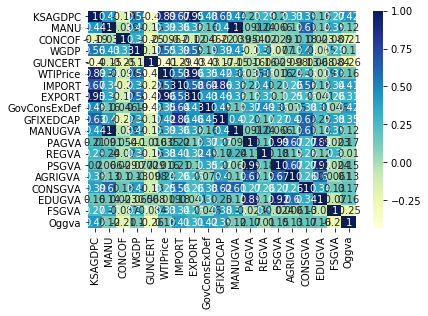

In [46]:
#Some correlation analysis to see the strength of relationships between X and Y variables and any multicollinearity

sns.heatmap(DLdataset6.corr(), cmap="YlGnBu", annot = True)

In [333]:
#Taking differences of logs
DLdataset6 = Ldataset6.diff().dropna()

In [168]:
DLdataset6.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29 entries, 1991-12-31 to 2019-12-31
Data columns (total 20 columns):
KSAGDPC         29 non-null float64
CRISIS          29 non-null float64
MANU            29 non-null float64
CONCOF          29 non-null float64
WGDP            29 non-null float64
GUNCERT         29 non-null float64
WTIPrice        29 non-null float64
IMPORT          29 non-null float64
EXPORT          29 non-null float64
GovConsExDef    29 non-null float64
GFIXEDCAP       29 non-null float64
MANUGVA         29 non-null float64
PAGVA           29 non-null float64
REGVA           29 non-null float64
PSGVA           29 non-null float64
AGRIGVA         29 non-null float64
CONSGVA         29 non-null float64
EDUGVA          29 non-null float64
FSGVA           29 non-null float64
Oggva           29 non-null float64
dtypes: float64(20)
memory usage: 4.8 KB


In [169]:
DLdataset6 = DLdataset6.drop(['MANUGVA', 'PAGVA', 'REGVA', 'PSGVA', 'AGRIGVA', 'CONSGVA', 'EDUGVA', 'FSGVA' ], axis=1)

In [170]:
DLdataset6.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29 entries, 1991-12-31 to 2019-12-31
Data columns (total 12 columns):
KSAGDPC         29 non-null float64
CRISIS          29 non-null float64
MANU            29 non-null float64
CONCOF          29 non-null float64
WGDP            29 non-null float64
GUNCERT         29 non-null float64
WTIPrice        29 non-null float64
IMPORT          29 non-null float64
EXPORT          29 non-null float64
GovConsExDef    29 non-null float64
GFIXEDCAP       29 non-null float64
Oggva           29 non-null float64
dtypes: float64(12)
memory usage: 2.9 KB


In [171]:
# KPSS tests whether a seires is trend stationary. We might need to insert a time trend/detrend to improve forecast results

from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

In [172]:
kpss_test(DLdataset6)

ValueError: x of shape (29, 12) not understood

<h2> 4. Testing Causation using Granger’s Causality Test</h2> 


Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero. In simpler terms, the past values of time series (X) do not cause the other series (Y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis.

In [173]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=5
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    DLdataset6 = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in DLdataset6.columns:
        for r in DLdataset6.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            DLdataset6.loc[r, c] = min_p_value
    DLdataset6.columns = [var + '_x' for var in variables]
    DLdataset6.index = [var + '_y' for var in variables]
    return DLdataset6

grangers_causation_matrix(DLdataset6, variables = DLdataset6.columns)        

KSAGDPC_x  CRISIS_x  MANU_x  CONCOF_x  WGDP_x  GUNCERT_x  \
KSAGDPC_y          1.0000    0.2205  0.1083    0.0059  0.2278     0.7173   
CRISIS_y           0.0441    1.0000  0.0618    0.2069  0.4333     0.0084   
MANU_y             0.0000    0.1314  1.0000    0.0000  0.3295     0.0628   
CONCOF_y           0.0379    0.4320  0.5172    1.0000  0.0226     0.4012   
WGDP_y             0.1089    0.4582  0.2821    0.0018  1.0000     0.0040   
GUNCERT_y          0.0521    0.0089  0.0000    0.3575  0.1753     1.0000   
WTIPrice_y         0.0018    0.3469  0.0108    0.3365  0.7098     0.5521   
IMPORT_y           0.0815    0.0429  0.0063    0.0570  0.1707     0.1482   
EXPORT_y           0.0018    0.3707  0.0124    0.1840  0.7465     0.6694   
GovConsExDef_y     0.0011    0.0312  0.0624    0.0033  0.0104     0.2128   
GFIXEDCAP_y        0.3325    0.5758  0.2934    0.0000  0.0471     0.0480   
Oggva_y            0.0833    0.0091  0.0005    0.0396  0.0014     0.0010   

                WTIPrice_x  IMPORT_x  EXPORT_x  GovConsExDef_x  GFIXEDCAP_x  \
KSAGDPC_y           0.0925    0.0532    0.0237          0.2648       0.0487   
CRISIS_y            0.0597    0.0163    0.0793          0.4166       0.1644   
MANU_y              0.0326    0.0000    0.0022          0.0073       0.0000   
CONCOF_y            0.1338    0.0235    0.0418          0.3257       0.0332   
WGDP_y              0.4327    0.1866    0.4084          0.0791       0.1901   
GUNCERT_y           0.0333    0.3192    0.0241          0.0175       0.2414   
WTIPrice_y          1.0000    0.3970    0.1996          0.2809       0.6672   
IMPORT_y            0.0402    1.0000    0.0041          0.1520       0.0594   
EXPORT_y            0.1580    0.2923    1.0000          0.2778       0.6576   
GovConsExDef_y      0.0002    0.0089    0.0039          1.0000       0.0204   
GFIXEDCAP_y         0.1375    0.3676    0.1125          0.0500       1.0000   
Oggva_y             0.1769    0.0304    0.0552          0.4100       0.0381   

                Oggva_x  
KSAGDPC_y        0.2923  
CRISIS_y         0.5621  
MANU_y           0.2798  
CONCOF_y         0.1363  
WGDP_y           0.1039  
GUNCERT_y        0.0269  
WTIPrice_y       0.2384  
IMPORT_y         0.0030  
EXPORT_y         0.3634  
GovConsExDef_y   0.0836  
GFIXEDCAP_y      0.5140  
Oggva_y          1.0000

In [174]:
#Variables seem to have specific intermixed relationships as the pvalues are significant and insignificant for all variable
#depending on the variable they are mapped agianst, in the matrix above

<h2> 5. Cointegration Test <h/2>

When two or more time series are cointegrated, it means they have a long run, statistically significant relationship. This is the basic premise on which Vector Autoregression(VAR) models is based on.

In [175]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(DLdataset6, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(DLdataset6,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(dataset6.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(DLdataset6)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
KSAGDPC ::  1171.17   > 311.1288  =>   True
CRISIS ::  395.12    > 263.2603  =>   True
MANU   ::  275.39    > 219.4051  =>   True
CONCOF ::  193.67    > 179.5199  =>   True
WGDP   ::  138.06    > 143.6691  =>   False
GUNCERT ::  93.25     > 111.7797  =>   False
WTIPrice ::  55.48     > 83.9383   =>   False
IMPORT ::  28.94     > 60.0627   =>   False
EXPORT ::  12.29     > 40.1749   =>   False
GovConsExDef ::  4.15      > 24.2761   =>   False
GFIXEDCAP ::  1.48      > 12.3212   =>   False
MANUGVA ::  0.16      > 4.1296    =>   False


<h2> 6. Split series into training and test <h/2>


In [176]:
nobs = 5
DLdataset6_train, DLdataset6_test = DLdataset6[0:-nobs], DLdataset6[-nobs:]

# Check size
print(DLdataset6_train.shape)
print(DLdataset6_test.shape)

(24, 12)
(5, 12)


<h2> 7. Select the Order of VAR <h/2>


To select the right order of the VAR model, we iteratively fit increasing orders of VAR model and pick the order that gives a model with least AIC.

Though the usual practice is to look at the AIC, you can also check other best fit comparison estimates of BIC, FPE and HQIC.

In [177]:
#our VAR is going back only as far as one lag due to the limitation of number of rows

model = VAR(DLdataset6_train)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1


C:\Users\muanwer\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  % freq, ValueWarning)


LinAlgError: 11-th leading minor of the array is not positive definite

In [178]:
#An alternate way to choose the order of VAR is given below. Since we do not have much data (rows) we keep the max lags to 1
x = model.select_order(maxlags=1)
x.summary()

#Bias Variance tradeoff in mind with AIC and SBC

LinAlgError: 11-th leading minor of the array is not positive definite

<h2> 8. Train the VAR Model of Selected Order <h/2>

In [179]:
model_fitted = model.fit(4)
model_fitted.summary()

C:\Users\muanwer\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:1374: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self._cov_params()))
C:\Users\muanwer\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\muanwer\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\muanwer\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 19, May, 2020
Time:                     19:12:11
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                   -795.668
Nobs:                     20.0000    HQIC:                  -819.228
Log likelihood:           8496.88    FPE:                    0.00000
AIC:                     -824.943    Det(Omega_mle):         0.00000
--------------------------------------------------------------------
Results for equation KSAGDPC
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.050438              NAN              NAN             NAN
L1.KSAGDPC             -0.257545         0.000000     -7415117.284           0.000
L1.CRISIS              -0.416383              NAN 

<h2>  9. Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic <h/2>


In [180]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)
for col, val in zip(DLdataset6.columns, out):
    print(adjust(col), ':', round(val, 2))

KSAGDPC : 1.7
CRISIS : 1.49
MANU   : 0.84
CONCOF : 1.04
WGDP   : 2.19
GUNCERT : 0.91
WTIPrice : 1.88
IMPORT : 1.38
EXPORT : 0.92
GovConsExDef : 0.53
GFIXEDCAP : 1.94
Oggva  : 0.3


<h2>  10. Forecast VAR model <h/2>


In [181]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = DLdataset6.values[-lag_order:]
forecast_input

4


array([[-1.43636895e-02, -4.05465108e-01,  3.14033182e-02,
         3.37977026e-04,  1.39230574e-02,  8.62303249e-02,
        -1.14440862e-01, -2.49067236e-01, -8.11901547e-02,
        -1.46430121e-01, -1.46891120e-01,  2.82113459e-02],
       [ 6.54639978e-02,  0.00000000e+00,  1.28604261e-02,
         2.22786980e-03,  2.00200692e-02, -1.27607592e-01,
         1.56631231e-01,  2.00006667e-02,  1.77334015e-01,
         9.85534800e-03,  0.00000000e+00, -3.70766974e-02],
       [ 1.32931702e-01,  0.00000000e+00,  2.06830724e-02,
         4.54376462e-04,  1.90414414e-02,  3.53792715e-02,
         2.45743383e-01,  3.88398333e-02,  2.68754063e-01,
         1.37427828e-01, -3.05244582e-02,  3.59726263e-02],
       [ 8.15816793e-03,  0.00000000e+00,  1.61080106e-02,
        -6.12326820e-03,  2.85848691e-02,  5.43390036e-01,
        -1.32862951e-01, -1.43887375e-02, -1.25375480e-01,
        -3.56271148e-02,  5.86074270e-02, -4.49172758e-02]])

In [182]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
DLdataset6_forecast = pd.DataFrame(fc, index=DLdataset6.index[-nobs:], columns=DLdataset6.columns + '_forecast')
DLdataset6_forecast

KSAGDPC_forecast  CRISIS_forecast  MANU_forecast  CONCOF_forecast  \
date                                                                            
2015-12-31          0.198462        -0.141133       0.086567        -0.013438   
2016-12-31         -0.038630         0.302081       0.033591        -0.007449   
2017-12-31         -0.003645         0.059678       0.078398         0.014745   
2018-12-31          0.352748        -0.281828       0.097453         0.004576   
2019-12-31          0.117060         0.173784       0.051057        -0.000995   

            WGDP_forecast  GUNCERT_forecast  WTIPrice_forecast  \
date                                                             
2015-12-31       0.024587          0.292767           0.289847   
2016-12-31      -0.004472         -0.248785          -0.152413   
2017-12-31       0.024475         -0.023375          -0.056773   
2018-12-31       0.043625         -0.717594           0.511425   
2019-12-31       0.025729          0.321882           0.108260   

            IMPORT_forecast  EXPORT_forecast  GovConsExDef_forecast  \
date                                                                  
2015-12-31         0.085650         0.338518              -0.026024   
2016-12-31         0.033796        -0.068758               0.119861   
2017-12-31         0.018756        -0.110516               0.008402   
2018-12-31         0.238908         0.579275               0.240841   
2019-12-31         0.272810         0.179779               0.192733   

            GFIXEDCAP_forecast  Oggva_forecast  
date                                            
2015-12-31            0.089097        0.080473  
2016-12-31            0.026267        0.067736  
2017-12-31            0.126503        0.000240  
2018-12-31            0.290315        0.072288  
2019-12-31            0.148479        0.024973

<h2>  11. Plot of forecast vs. actuals <h/2>  

In [183]:
DLdataset6_test

KSAGDPC    CRISIS      MANU    CONCOF      WGDP   GUNCERT  \
date                                                                     
2015-12-31 -0.144930  0.405465  0.063606  0.002336  0.016545  0.289942   
2016-12-31 -0.014364 -0.405465  0.031403  0.000338  0.013923  0.086230   
2017-12-31  0.065464  0.000000  0.012860  0.002228  0.020020 -0.127608   
2018-12-31  0.132932  0.000000  0.020683  0.000454  0.019041  0.035379   
2019-12-31  0.008158  0.000000  0.016108 -0.006123  0.028585  0.543390   

            WTIPrice    IMPORT    EXPORT  GovConsExDef  GFIXEDCAP     Oggva  
date                                                                         
2015-12-31 -0.639902 -0.003929 -0.487623      0.012376   0.024898  0.045985  
2016-12-31 -0.114441 -0.249067 -0.081190     -0.146430  -0.146891  0.028211  
2017-12-31  0.156631  0.020001  0.177334      0.009855   0.000000 -0.037077  
2018-12-31  0.245743  0.038840  0.268754      0.137428  -0.030524  0.035973  
2019-12-31 -0.132863 -0.014389 -0.125375     -0.035627   0.058607 -0.044917

In [184]:
DLdataset6_forecast

KSAGDPC_forecast  CRISIS_forecast  MANU_forecast  CONCOF_forecast  \
date                                                                            
2015-12-31          0.198462        -0.141133       0.086567        -0.013438   
2016-12-31         -0.038630         0.302081       0.033591        -0.007449   
2017-12-31         -0.003645         0.059678       0.078398         0.014745   
2018-12-31          0.352748        -0.281828       0.097453         0.004576   
2019-12-31          0.117060         0.173784       0.051057        -0.000995   

            WGDP_forecast  GUNCERT_forecast  WTIPrice_forecast  \
date                                                             
2015-12-31       0.024587          0.292767           0.289847   
2016-12-31      -0.004472         -0.248785          -0.152413   
2017-12-31       0.024475         -0.023375          -0.056773   
2018-12-31       0.043625         -0.717594           0.511425   
2019-12-31       0.025729          0.321882           0.108260   

            IMPORT_forecast  EXPORT_forecast  GovConsExDef_forecast  \
date                                                                  
2015-12-31         0.085650         0.338518              -0.026024   
2016-12-31         0.033796        -0.068758               0.119861   
2017-12-31         0.018756        -0.110516               0.008402   
2018-12-31         0.238908         0.579275               0.240841   
2019-12-31         0.272810         0.179779               0.192733   

            GFIXEDCAP_forecast  Oggva_forecast  
date                                            
2015-12-31            0.089097        0.080473  
2016-12-31            0.026267        0.067736  
2017-12-31            0.126503        0.000240  
2018-12-31            0.290315        0.072288  
2019-12-31            0.148479        0.024973

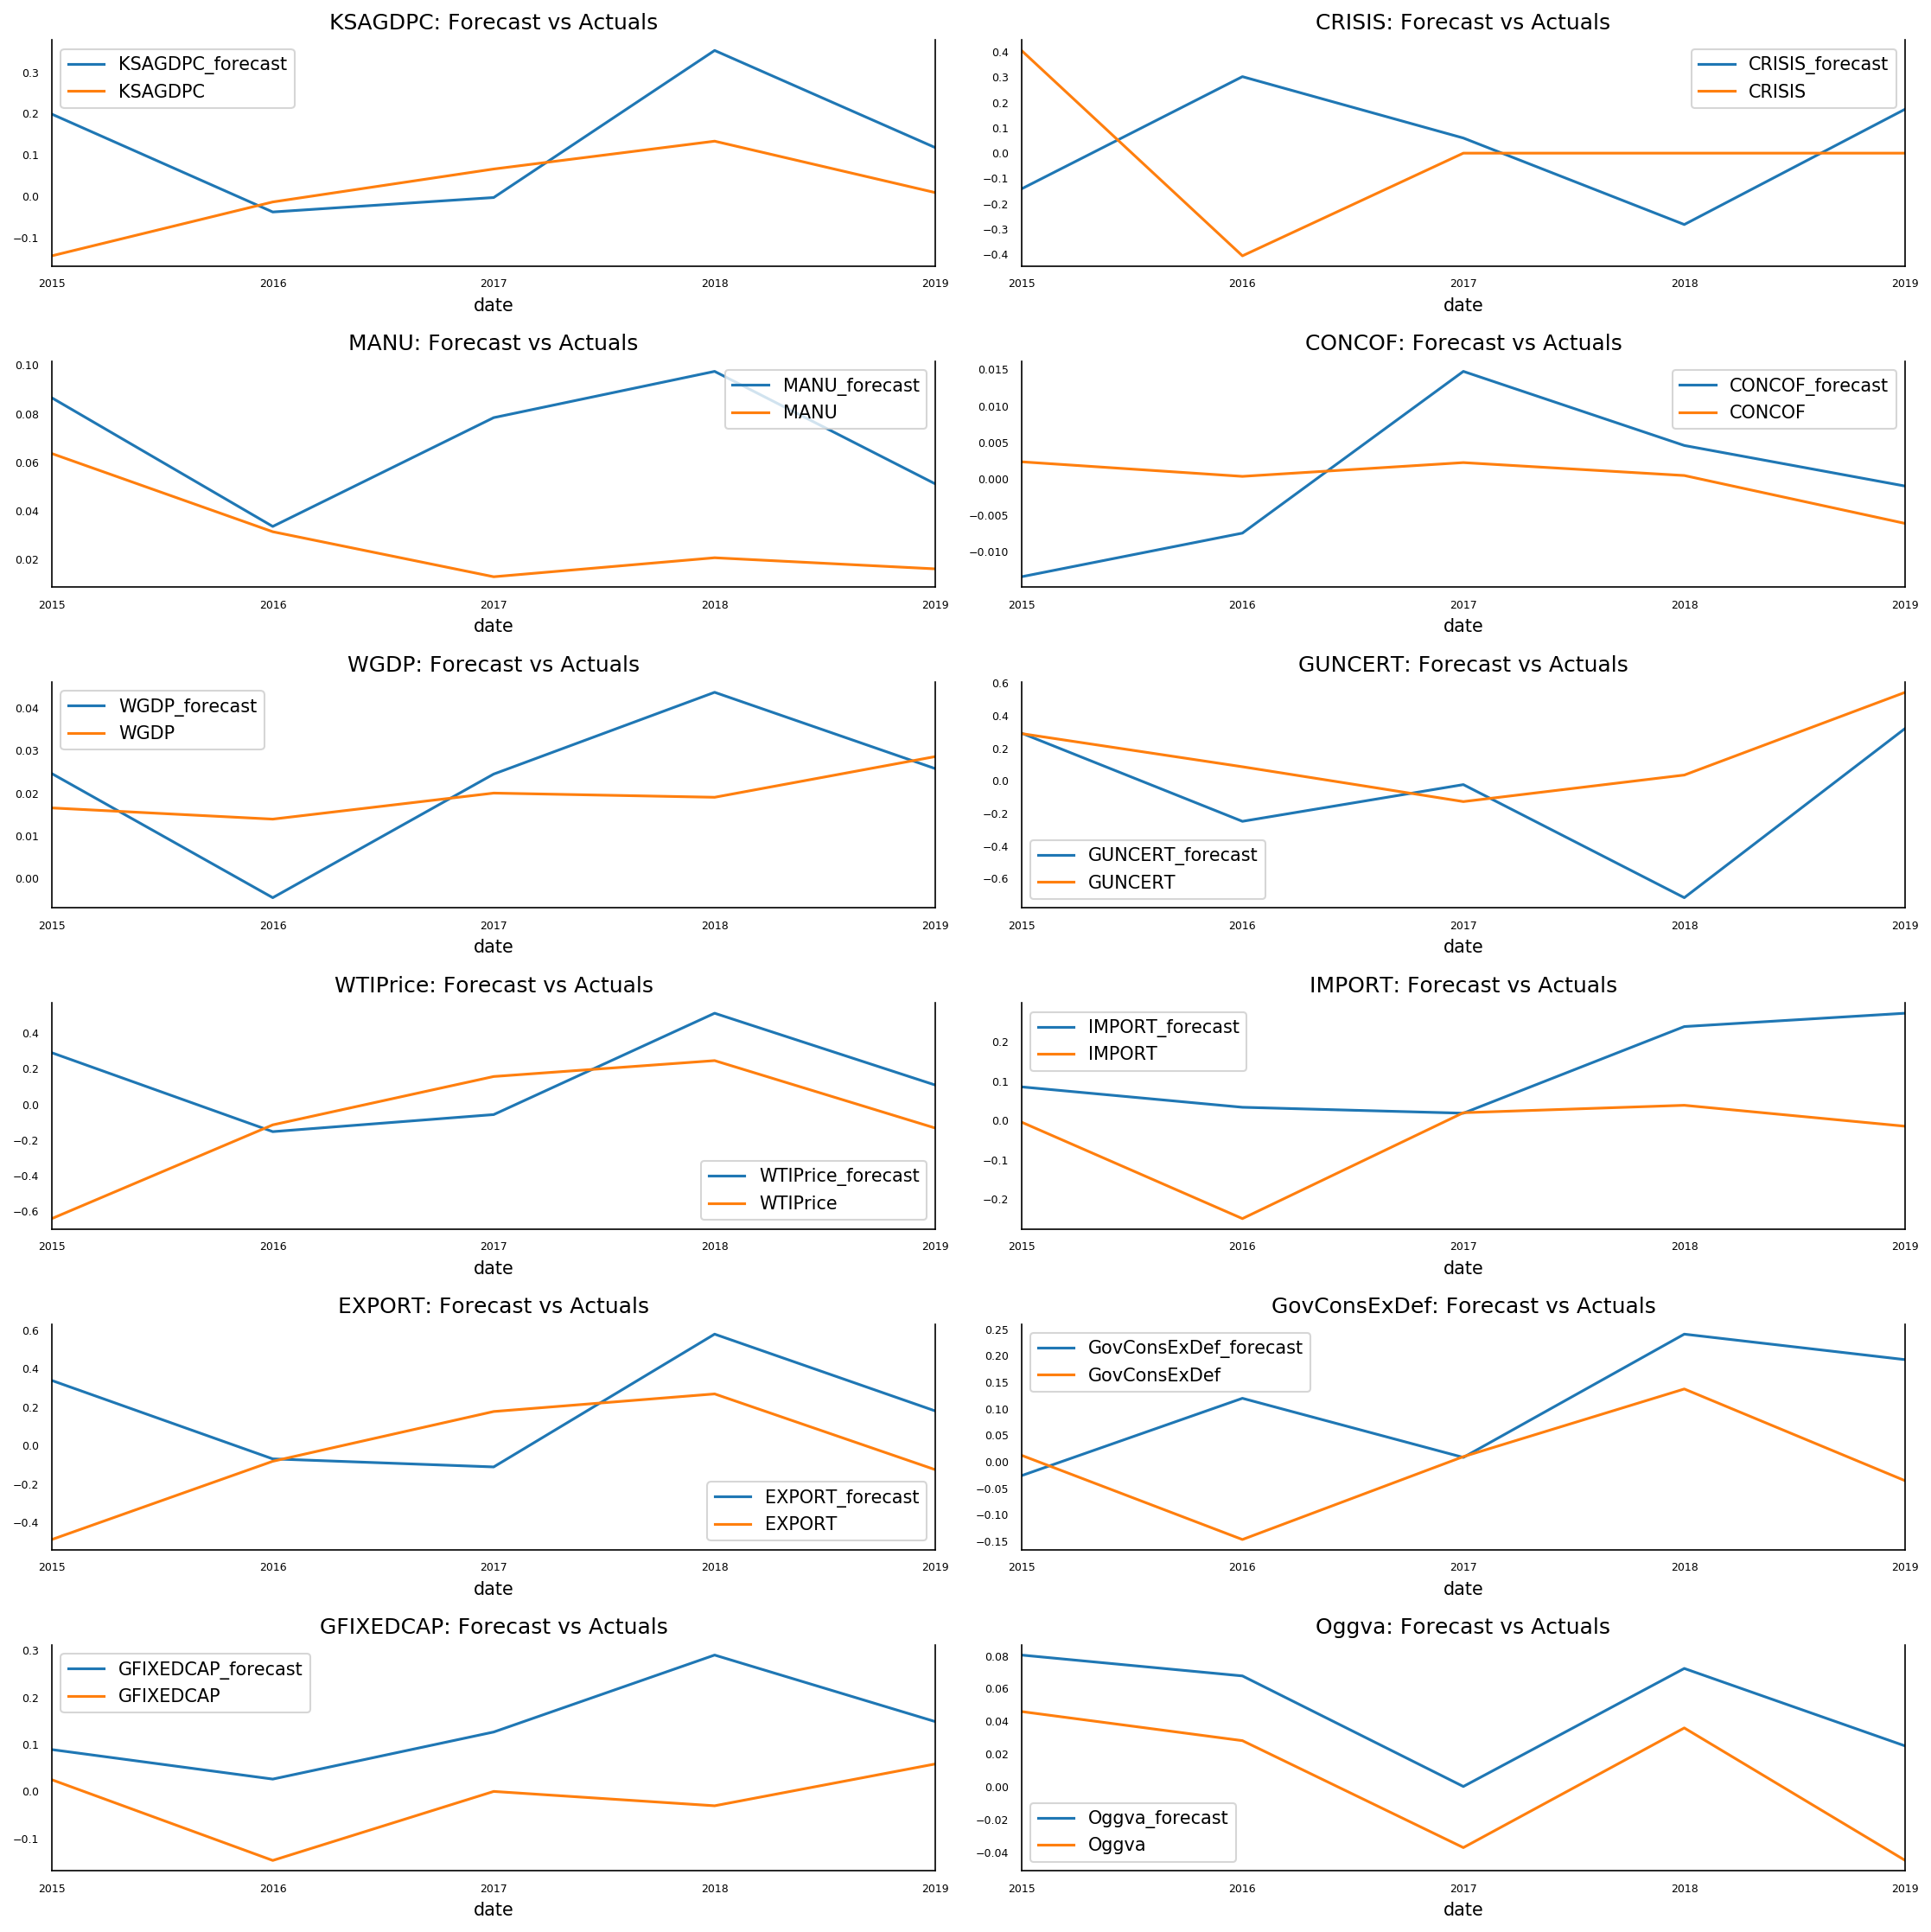

In [187]:
#Plot the forecasted values vs. the test values

fig, axes = plt.subplots(nrows=int(len(DLdataset6.columns)/2), ncols=2, dpi=150, figsize=(15,15))
for i, (col,ax) in enumerate(zip(DLdataset6.columns, axes.flatten())):
    DLdataset6_forecast[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    DLdataset6_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [188]:
#error calc

from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: KGDPC')
accuracy_prod = forecast_accuracy(DLdataset6_forecast['KSAGDPC_forecast'].values, DLdataset6_test['KSAGDPC'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: MANU')
accuracy_prod = forecast_accuracy(DLdataset6_forecast['MANU_forecast'].values, DLdataset6_test['MANU'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: CONCOF')
accuracy_prod = forecast_accuracy(DLdataset6_forecast['CONCOF_forecast'].values, DLdataset6_test['CONCOF'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: WGDP')
accuracy_prod = forecast_accuracy(DLdataset6_forecast['WGDP_forecast'].values, DLdataset6_test['WGDP'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: GUNCERT')
accuracy_prod = forecast_accuracy(DLdataset6_forecast['GUNCERT_forecast'].values, DLdataset6_test['GUNCERT'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: WTIPrice')
accuracy_prod = forecast_accuracy(DLdataset6_forecast['WTIPrice_forecast'].values, DLdataset6_test['WTIPrice'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: IMPORT')
accuracy_prod = forecast_accuracy(DLdataset6_forecast['IMPORT_forecast'].values, DLdataset6_test['IMPORT'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: EXPORT')
accuracy_prod = forecast_accuracy(DLdataset6_forecast['EXPORT_forecast'].values, DLdataset6_test['EXPORT'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: KGDPC
mape   :  4.0234
me     :  0.1157
mae    :  0.1531
mpe    :  2.6534
rmse   :  0.1916
corr   :  0.2054
minmax :  0.53

Forecast Accuracy of: MANU
mape   :  2.2816
me     :  0.0405
mae    :  0.0405
mpe    :  2.2816
rmse   :  0.0489
corr   :  0.1683
minmax :  0.5277

Forecast Accuracy of: CONCOF
mape   :  9.0637
me     :  -0.0004
mae    :  0.0091
mpe    :  -3.1877
rmse   :  0.0101
corr   :  0.0445
minmax :  5.2776

Forecast Accuracy of: WGDP
mape   :  0.6842
me     :  0.0032
mae    :  0.0117
mpe    :  0.1157
rmse   :  0.0144
corr   :  0.4307
minmax :  0.4988

Forecast Accuracy of: GUNCERT
mape   :  5.2804
me     :  -0.2405
mae    :  0.2833
mpe    :  -5.2765
rmse   :  0.3845
corr   :  0.6256
minmax :  4.2252

Forecast Accuracy of: WTIPrice
mape   :  1.2086
me     :  0.237
mae    :  0.3376
mpe    :  -0.6435
rmse   :  0.4561
corr   :  0.0062
minmax :  1.397

Forecast Accuracy of: IMPORT
mape   :  9.8214
me     :  0.1717
mae    :  0.1722
mpe    :  -7.7609
rmse   : 

In [ ]:
model_fitted.irf_resim(orth=False, repl=1000, seed=None, burn=100, cum=False)


In [ ]:
model_fitted.plot_acorr()
plt.tight_layout();

In [226]:
lag_order = model_fitted.k_ar
# forecast 2 periods forward based on data until 2019
ForwardForecast = model_fitted.forecast(DLdataset6.values[-lag_order:],2)
ForwardForecast

array([[-0.28890403,  0.01163465, -0.0134904 , -0.06132269, -1.05918852,
        -0.30229862, -0.67273768, -0.52464536, -0.27444276, -0.26273457],
       [ 0.19972917,  0.25289671,  0.0265027 ,  0.06711465, -1.85696387,
         0.96297133,  0.79735723,  0.80620739,  0.00216716, -0.28994045]])

In [ ]:
#For 2021, VAR is assuming that govt spending would return as strongly as it did in the past.
#Also assuming that oil prices and prod would return without considering supply glut
#Does not price in long term impact of social distancing on restaurants and religious tourism industry. 
#Hence it is showing a V shaped recovery which is not right. 19.97% increase in 2021
#Need to add dummy variables or other variables to account for this. But we have few rows and 10 equations already.
#Lucky have it fitted at 1st log difference because if we had to difference more, then many rows would have been lost

In [227]:
type(ForwardForecast)
#Plot this array above

numpy.ndarray

NameError: name 'years' is not defined

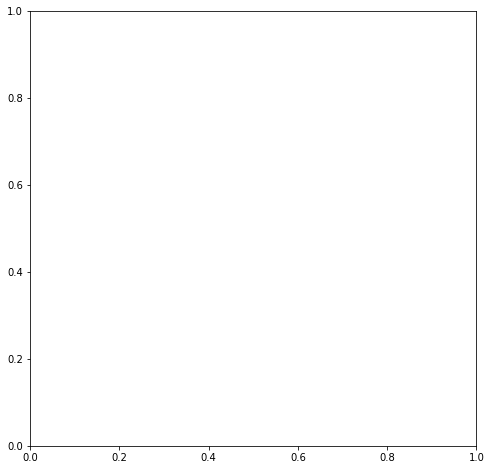

In [228]:
# set plot size for all plots that follow
plt.rcParams["figure.figsize"] = (8, 8)

# create the plot space upon which to plot the data
fig, ax = plt.subplots()
# add the x-axis and the y-axis to the plot
ax.bar(years, Pct_Change, color="grey")

# set plot title
ax.set(title="Covid19 Impact, CO")

# add labels to the axes
ax.set(xlabel="Year", ylabel="Percent Change");

C:\Users\muanwer\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:1100: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(self._forecast_vars(steps))


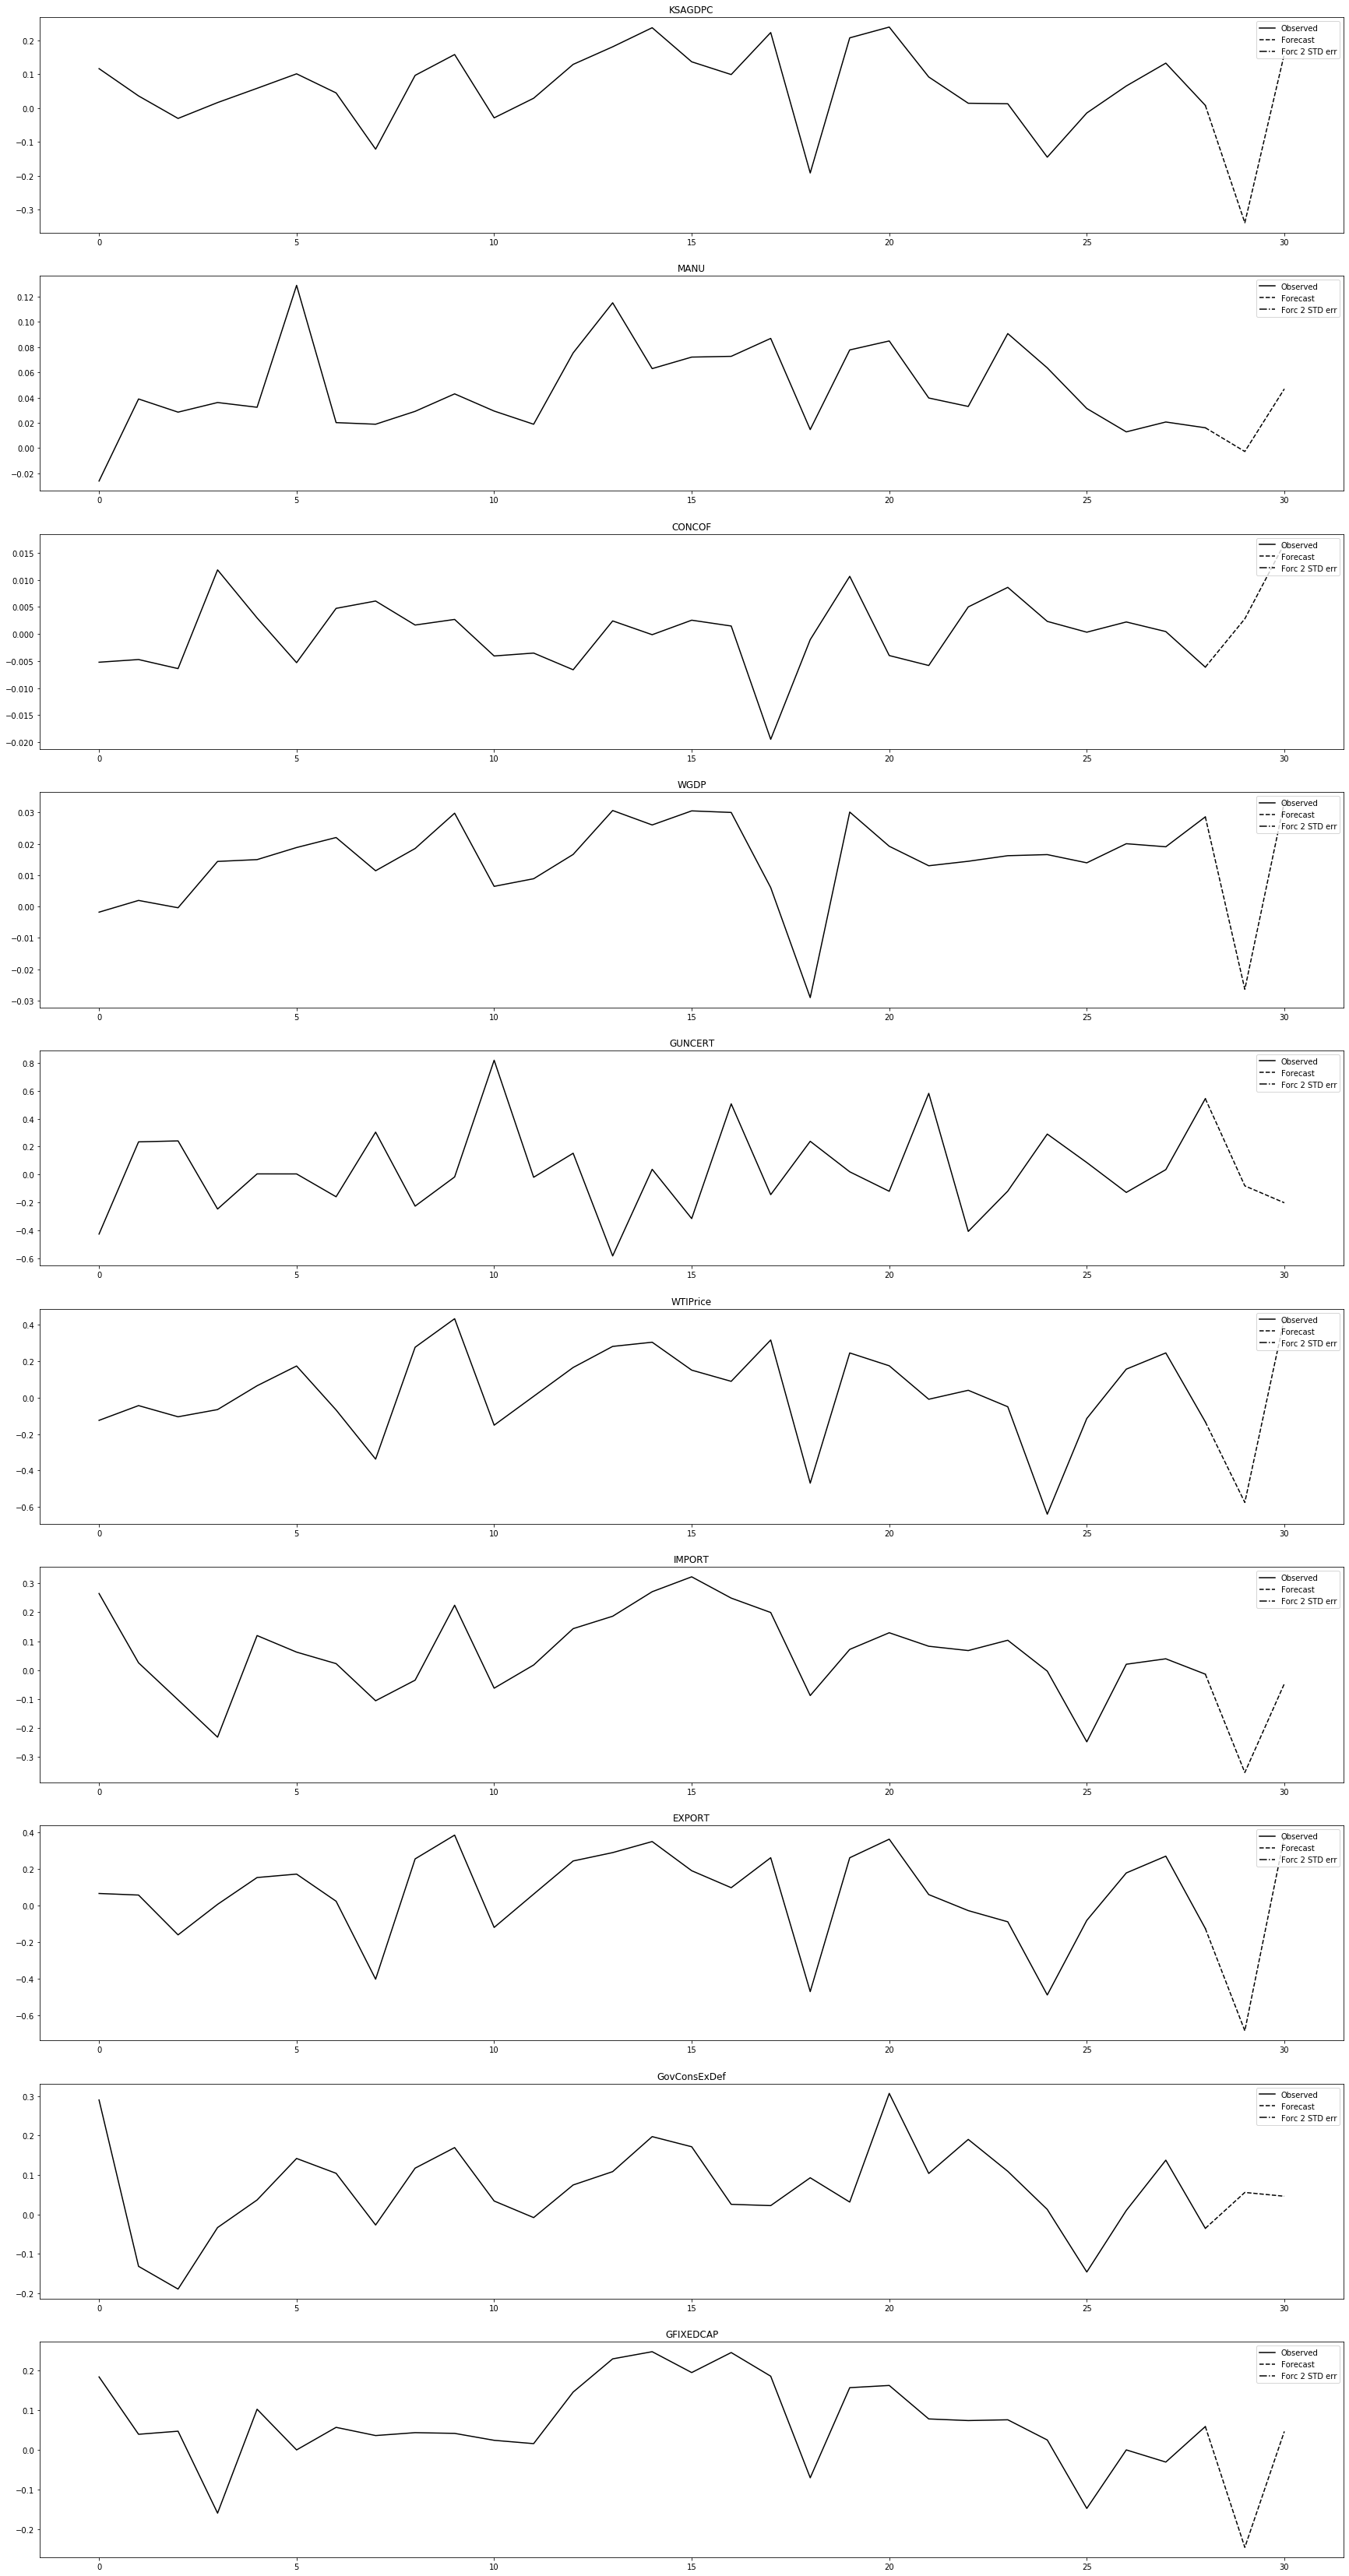

In [234]:
#GDP drop in 2020 only to recover after in 2021 - the V shaped recovery
plot_forecast = model_fitted.plot_forecast(2)
plot_forecast.set_figheight(60)
plot_forecast.set_figwidth(30)
plot_forecast.savefig('test.png', dpi = 80)


([<matplotlib.axis.XTick at 0x17cb3c4c390>,
 <a list of 2 Text xticklabel objects>)

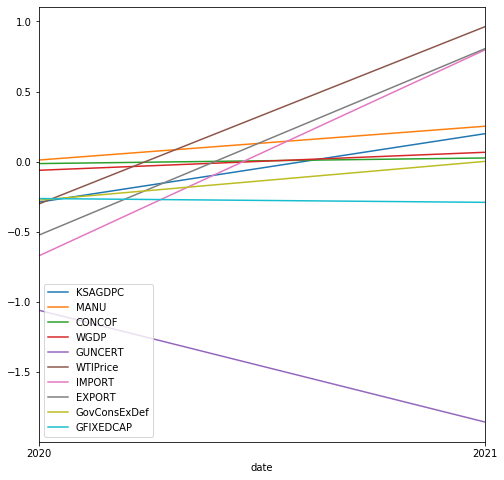

In [232]:
#Plot of 2021 forecast V shaped recovery

plot_array = model_fitted.forecast(DLdataset6.values[-lag_order:],2)
plot_array = pd.DataFrame(plot_array)
plot_array = plot_array.rename(columns = dict(enumerate(DLdataset6.columns)))
plot_array['date'] = ['2020','2021']
plot_array.set_index('date', inplace = True)
plot_array.plot()
plt.xticks(np.arange(len(plot_array.index)), plot_array.index)

In [231]:
#Original variables changed to Log differencing

DLdataset6.describe()


KSAGDPC       MANU     CONCOF       WGDP    GUNCERT   WTIPrice  \
count  30.000000  30.000000  30.000000  30.000000  30.000000  30.000000   
mean    0.059479   0.044399  -0.000406   0.014443   0.050220  -0.006511   
std     0.112272   0.037258   0.006286   0.013428   0.318945   0.303721   
min    -0.191644  -0.037588  -0.019464  -0.029093  -0.582164  -1.015748   
25%     0.009345   0.020320  -0.005088   0.009482  -0.139672  -0.112068   
50%     0.062011   0.034575   0.000396   0.016370   0.012425   0.023950   
75%     0.132016   0.072600   0.002662   0.021500   0.240389   0.174786   
max     0.239529   0.129032   0.011856   0.030617   0.818423   0.433581   

          IMPORT     EXPORT  GovConsExDef  GFIXEDCAP  
count  30.000000  30.000000     30.000000  30.000000  
mean    0.051882   0.023840      0.028760   0.064533  
std     0.146281   0.306900      0.233711   0.107656  
min    -0.249067  -1.049217     -1.049819  -0.158725  
25%    -0.030048  -0.086963     -0.003770   0.017836  
50%     0.050441   0.063654      0.055453   0.051788  
75%     0.139873   0.251033      0.132370   0.153460  
max     0.323142   0.383427      0.306935   0.246524

In [73]:
#Original variables changed to %
dataset4.describe()


KSAGDPC       MANU     CONCOF       WGDP    GUNCERT   WTIPrice  \
count  30.000000  30.000000  30.000000  30.000000  30.000000  30.000000   
mean    0.067755   0.046413  -0.000390   0.014637   0.106283   0.034769   
std     0.117674   0.039391   0.006337   0.013511   0.377940   0.269912   
min    -0.174489  -0.037000  -0.019468  -0.028677  -0.441331  -0.649061   
25%     0.009395   0.020685  -0.005126   0.009529  -0.130343  -0.108886   
50%     0.064054   0.035453   0.000400   0.016506   0.012531   0.024742   
75%     0.141218   0.075735   0.002692   0.021736   0.271770   0.198603   
max     0.270787   0.139175   0.012047   0.031094   1.267058   0.570838   

          IMPORT     EXPORT  GovConsExDef  GFIXEDCAP  
count  30.000000  30.000000     30.000000  30.000000  
mean    0.064111   0.064825      0.051005   0.072610  
std     0.154251   0.265903      0.180558   0.114473  
min    -0.220472  -0.649788     -0.650000  -0.146769  
25%    -0.029561  -0.083284     -0.003732   0.018002  
50%     0.051805   0.065725      0.057212   0.053165  
75%     0.150150   0.285368      0.141574   0.165874  
max     0.381462   0.467305      0.359254   0.279570

In [74]:
TwoSD = (np.std(DLdataset6)*2) + np.mean(DLdataset6)
print (TwoSD)

KSAGDPC         0.280250
MANU            0.117664
CONCOF          0.011956
WGDP            0.040847
GUNCERT         0.677387
WTIPrice        0.590722
IMPORT          0.339527
EXPORT          0.627324
GovConsExDef    0.488325
GFIXEDCAP       0.276227
dtype: float64


In [75]:
ThreeSD = (np.std(DLdataset6)*3) + np.mean(DLdataset6)
print (ThreeSD)

KSAGDPC         0.390635
MANU            0.154296
CONCOF          0.018136
WGDP            0.054049
GUNCERT         0.990971
WTIPrice        0.889339
IMPORT          0.483350
EXPORT          0.929065
GovConsExDef    0.718108
GFIXEDCAP       0.382074
dtype: float64


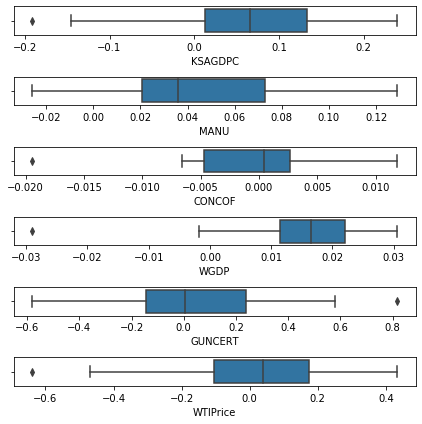

In [76]:
#Outlier analysis

fig, axs = plt.subplots(6, figsize = (6,6))
plt1 = sns.boxplot(DLdataset6_train['KSAGDPC'], ax = axs[0])
plt2 = sns.boxplot(DLdataset6_train['MANU'], ax = axs[1])
plt3 = sns.boxplot(DLdataset6_train['CONCOF'], ax = axs[2])
plt4 = sns.boxplot(DLdataset6_train['WGDP'], ax = axs[3])
plt5 = sns.boxplot(DLdataset6_train['GUNCERT'], ax = axs[4])
plt6 = sns.boxplot(DLdataset6_train['WTIPrice'], ax = axs[5])



plt.tight_layout()


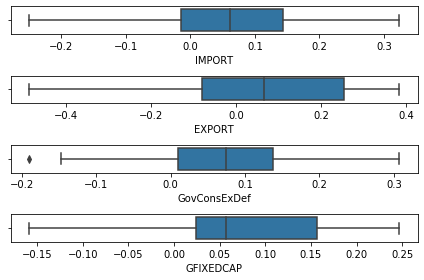

In [77]:
#Outlier analysis

fig, axs = plt.subplots(4, figsize = (6,4))

plt7 = sns.boxplot(DLdataset6_train['IMPORT'], ax = axs[0])
plt8 = sns.boxplot(DLdataset6_train['EXPORT'], ax = axs[1])
plt9 = sns.boxplot(DLdataset6_train['GovConsExDef'], ax = axs[2])
plt10 = sns.boxplot(DLdataset6_train['GFIXEDCAP'], ax = axs[3])



plt.tight_layout()

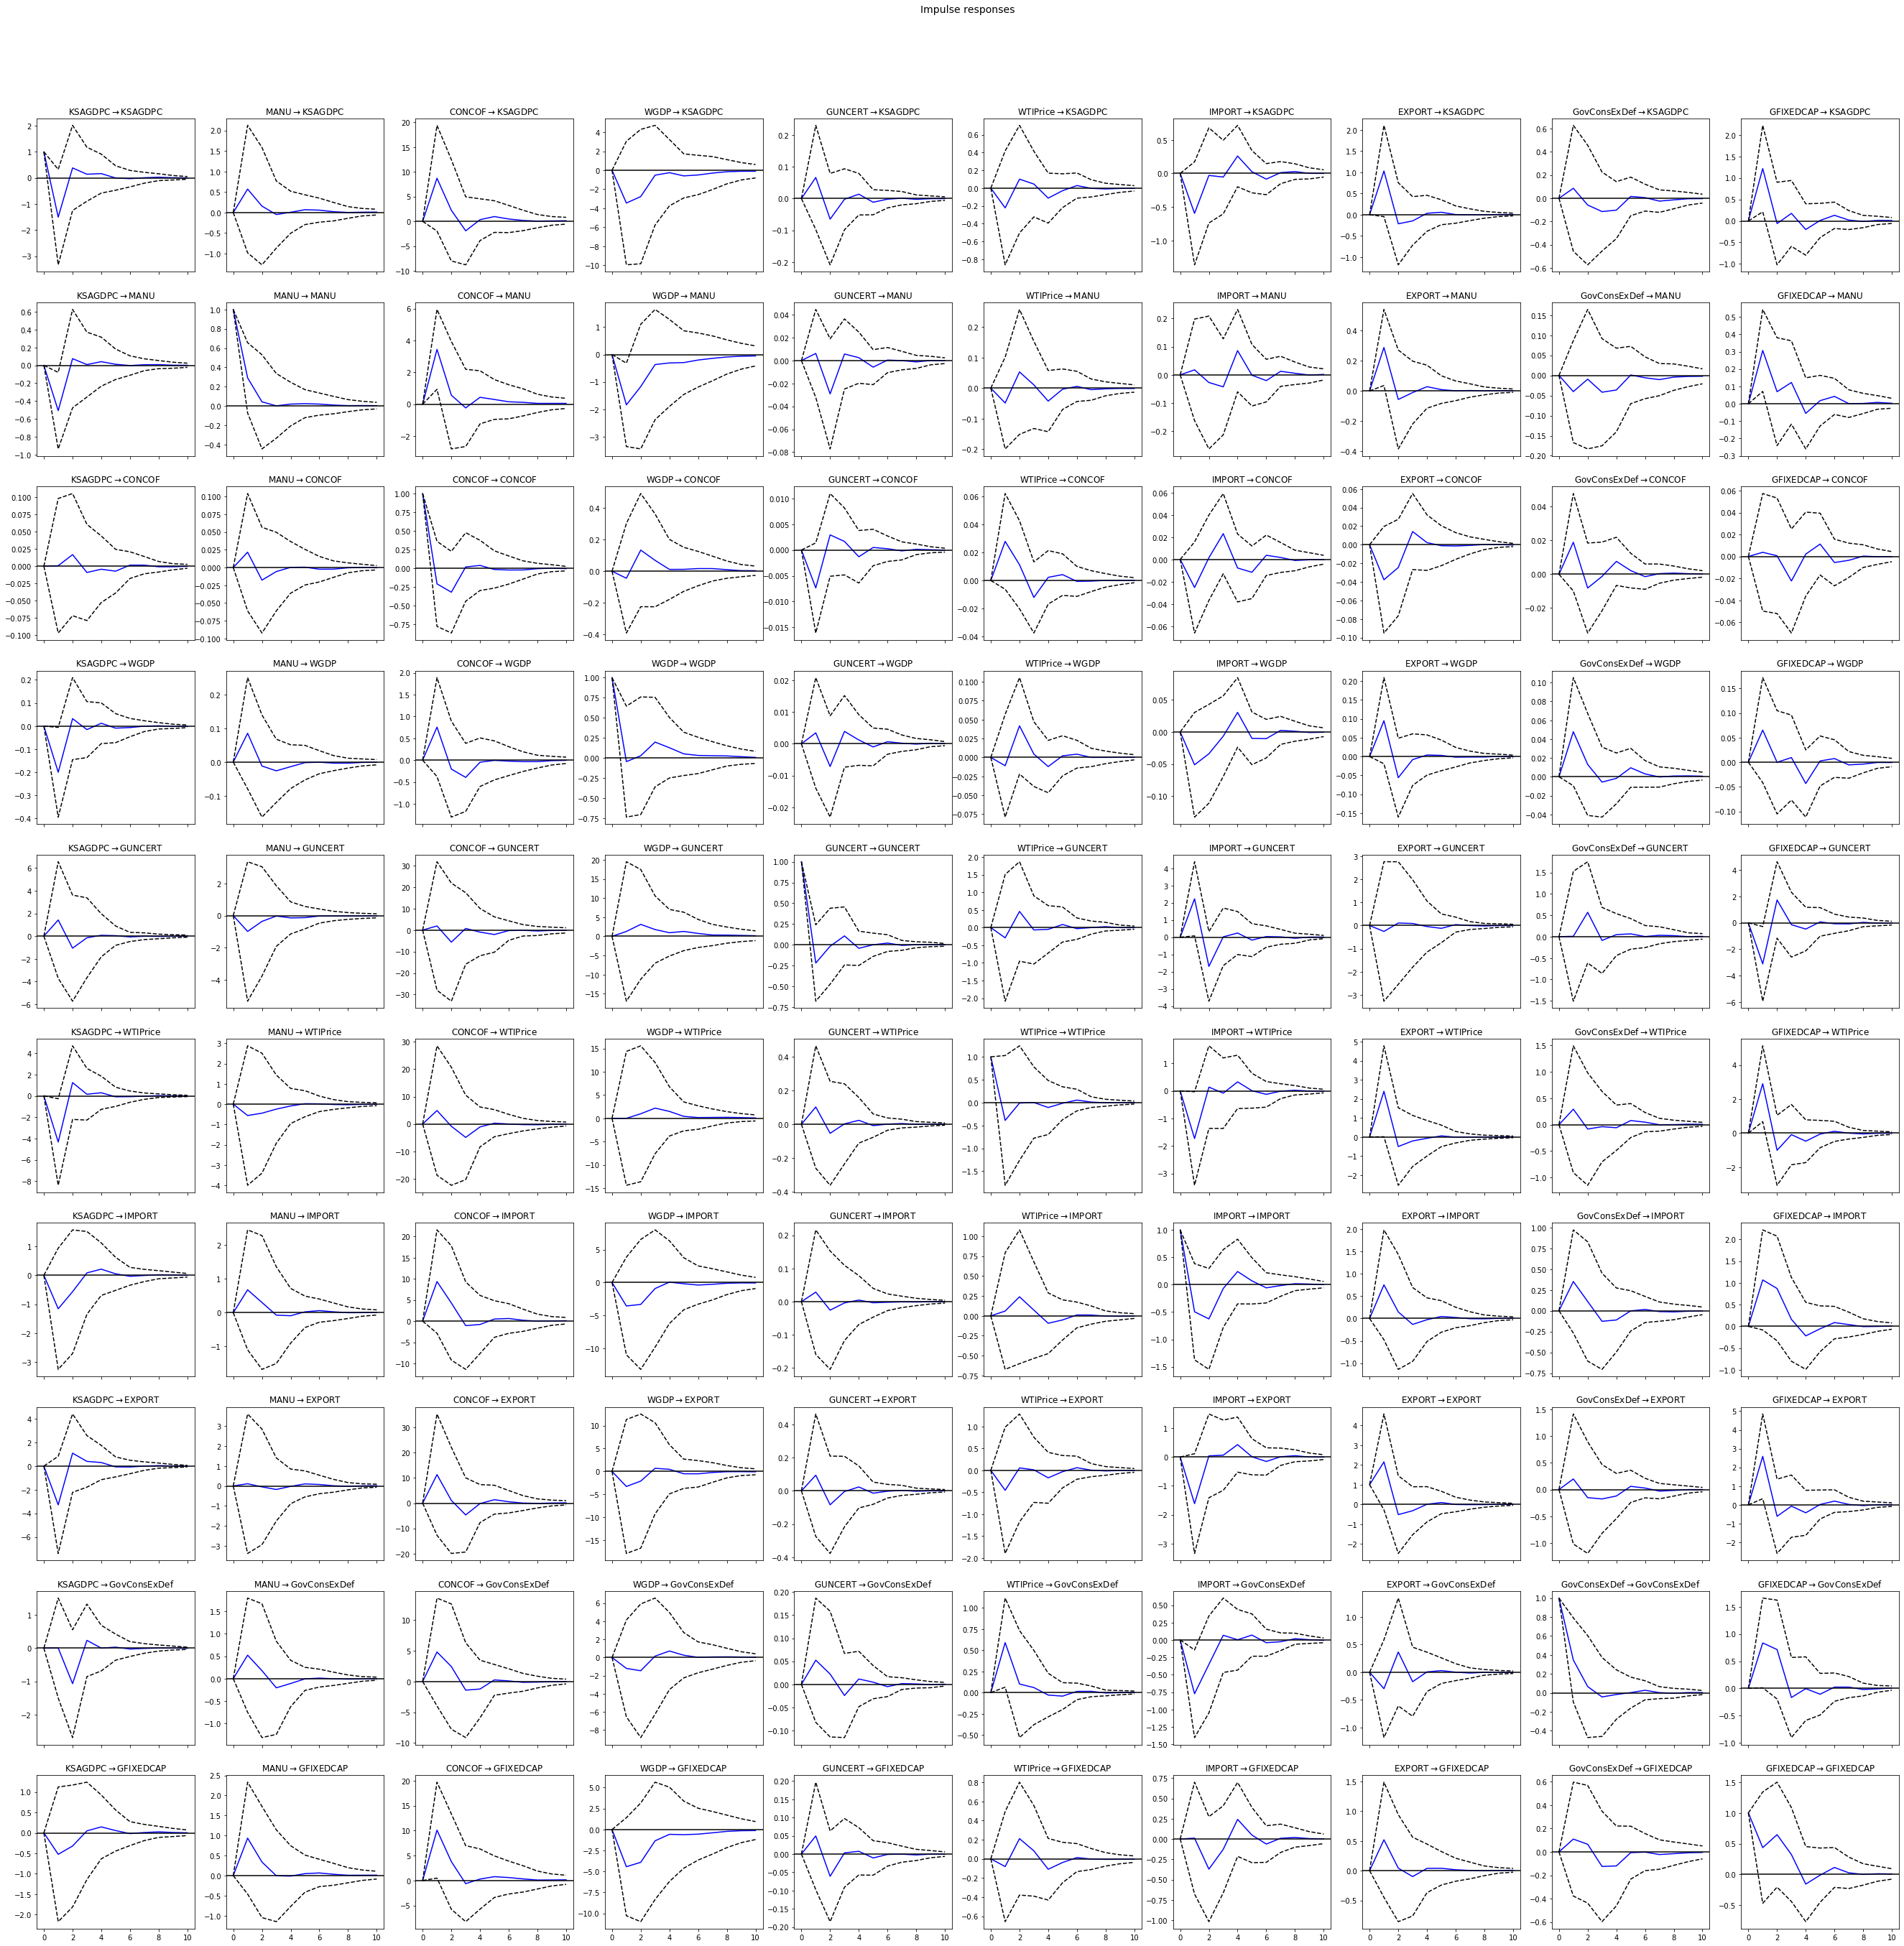

In [78]:
#impulse response function

#We introduce a joint impulse response function (jIRF) that allows for simultaneous shocks 
#from multiple variables in the VAR, rather than one at a time. The jIRF is independent of 
#the order of the variables in the VAR so the response functions are unique. 
#The traditional orthogonal IRF based upon the Cholesky decomposition allows only one 
#originating shock at a time and the response functions are dependent on the specific 
#order of the variables in the VAR. The generalized IRF is order independent but still 
#only allows one originating shock at a time. In many applications, we would like to measure 
#the reaction due to shocks from several variables at a time to estimate, say, the response to 
#policies that affect several economic sectors simultaneously. The jIRF is designed to address 
#these cases.


irf = model_fitted.irf(10)
plot_irf = irf.plot(orth=False)
plot_irf.set_figheight(40)
plot_irf.set_figwidth(40)
plot_irf.savefig('test3.png', dpi = 100)


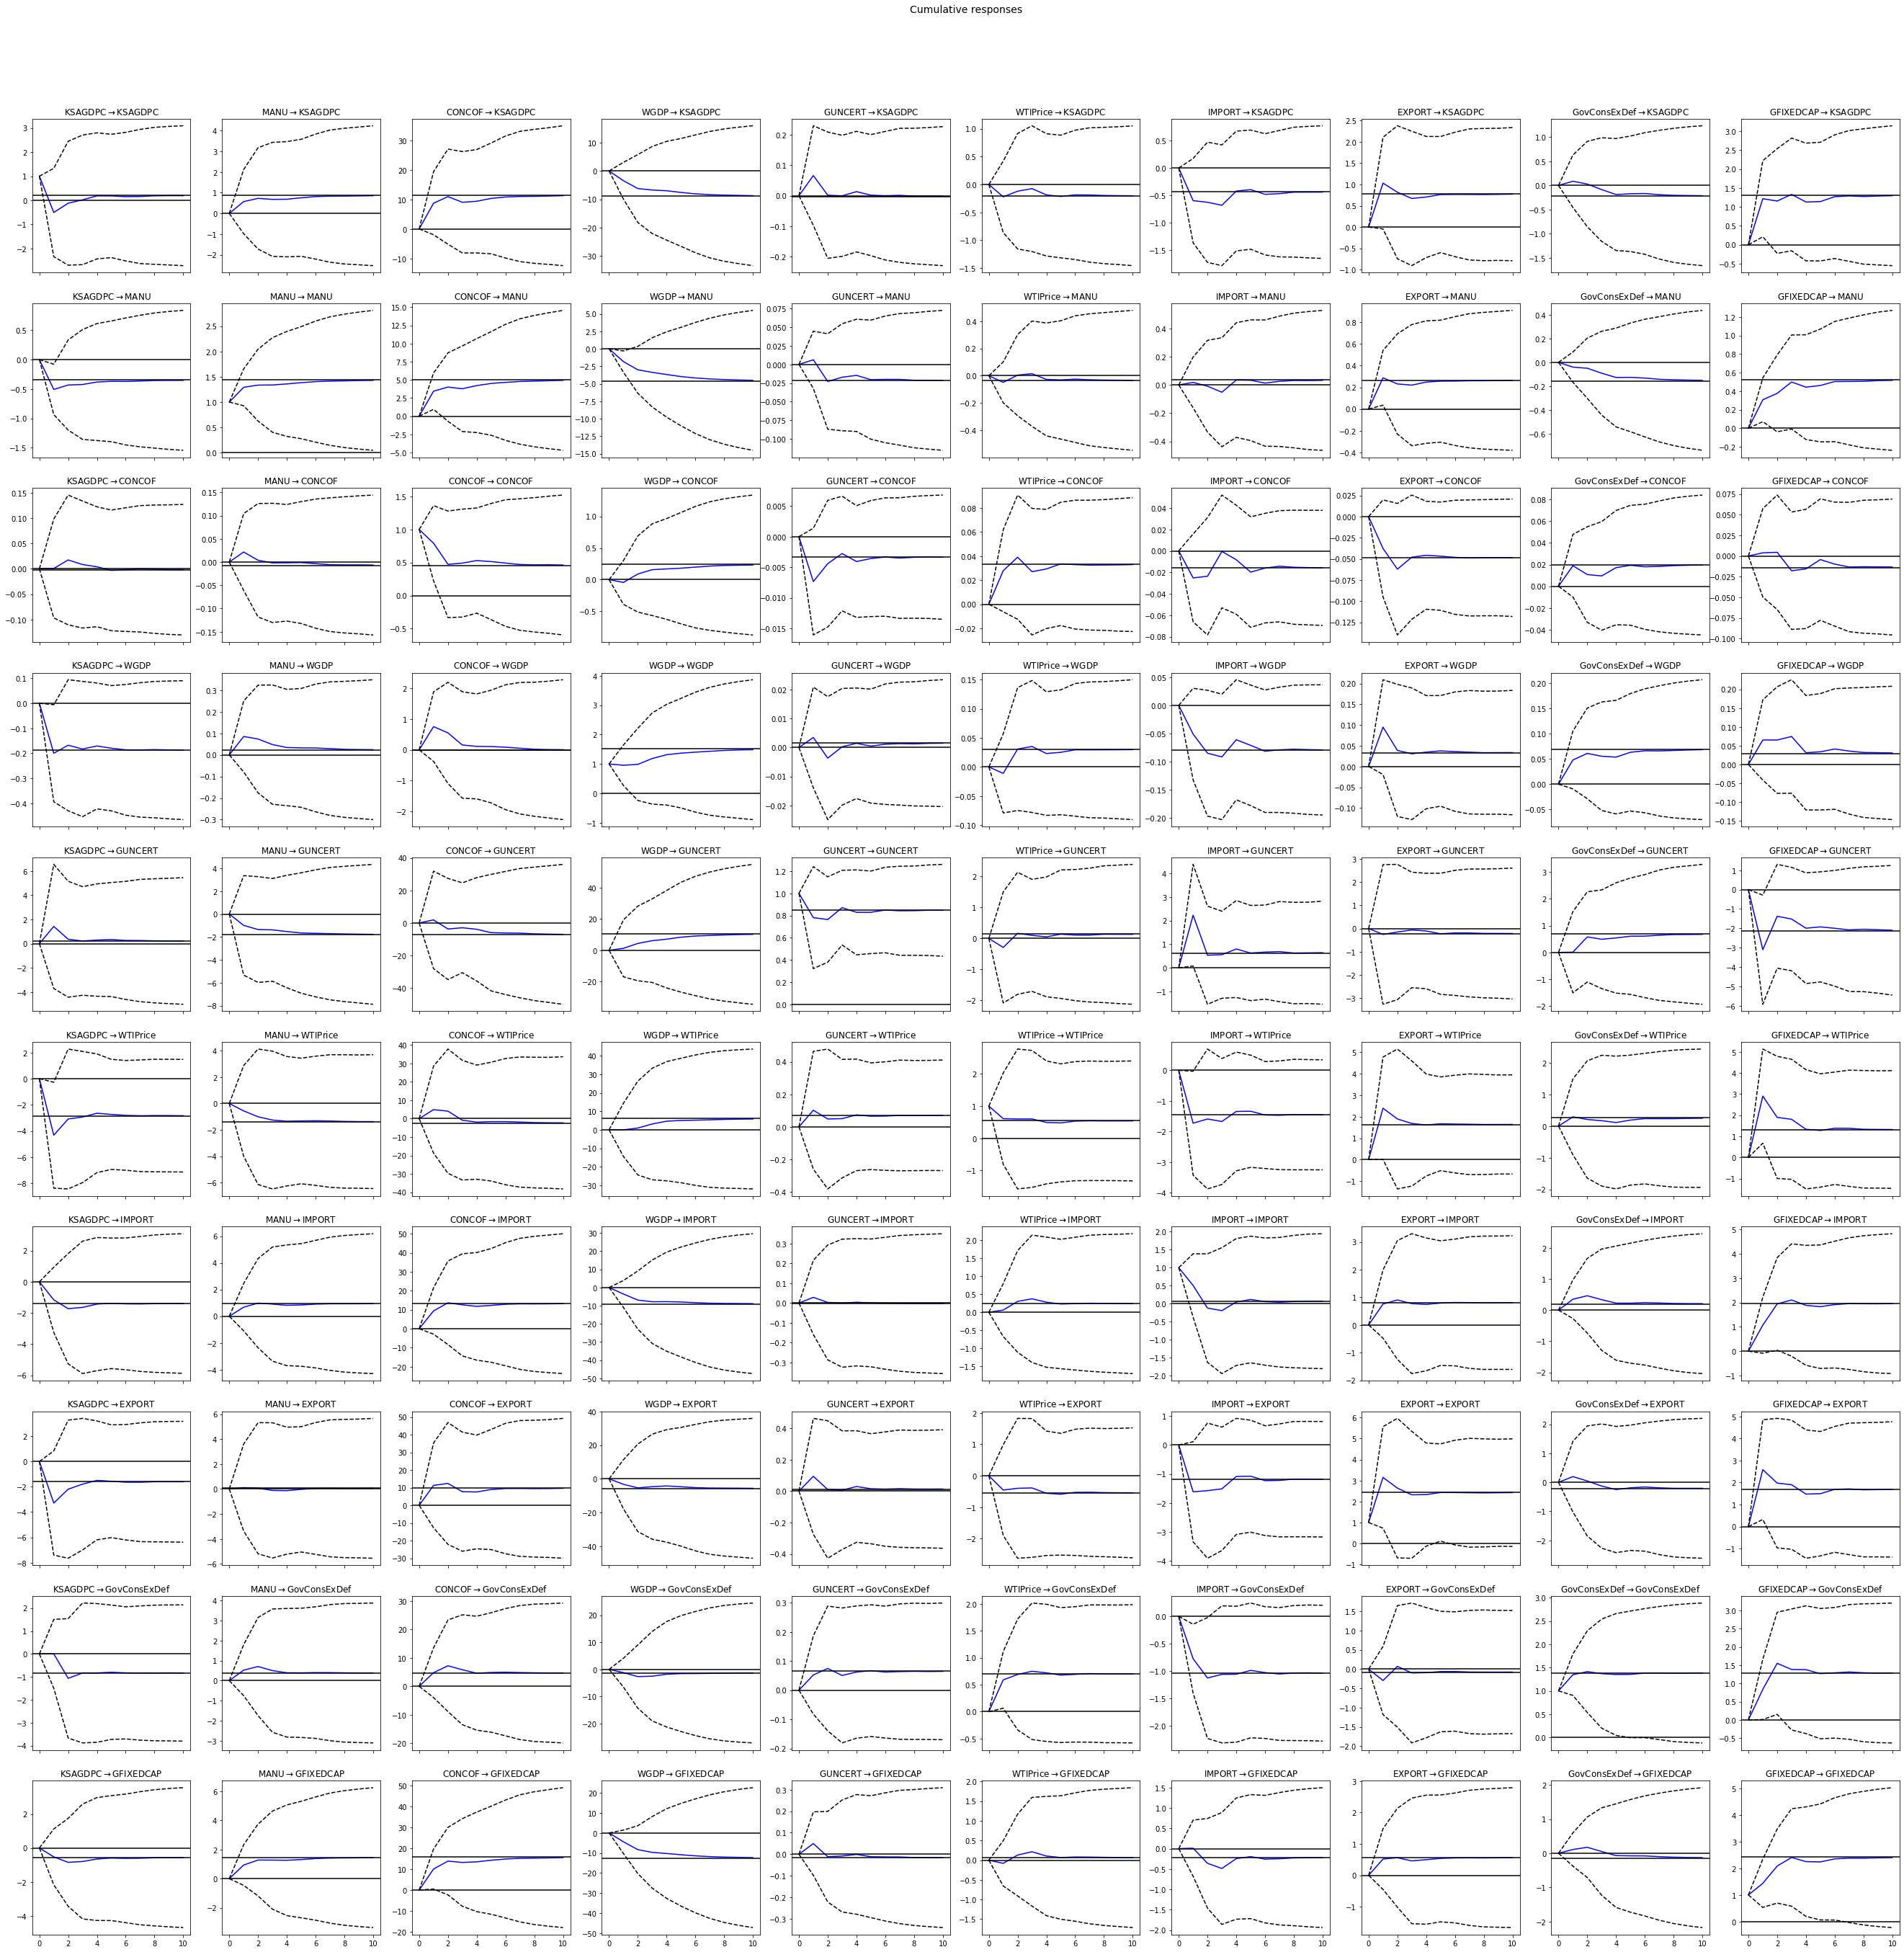

In [79]:
plot_irf_2 = irf.plot_cum_effects(orth=False)
plot_irf_2.set_figheight(40)
plot_irf_2.set_figwidth(40)
plot_irf_2.savefig('test4.png', dpi = 100)


In [80]:
#Compute Monte Carlo integrated error bands assuming normally distributed for impulse response functions

irfmc = model_fitted.irf_errband_mc(orth=False, repl=1000, signif=0.05, seed=None, burn=100, cum=False)

In [81]:
#GFIXEDCAP forecast looks good.
#GOVCONSExDef bottomed before model predicted. Dummy for war or other variables?



#As a next step, tune parameters. Introduce linear interpolation and train VAR until 2017 to forecast the rest.
#Check the expanding vs. rolling window on time periods
#Calculate RMSE, Durban Watson
#Time trend and see if need to detrend
#2015 as structural break dummy variable
#Test the model by imposing restrictions
#Introduce impulse response and see how the system behaves
#Increase


In [ ]:
#Lets build an ARIMA model on top of it

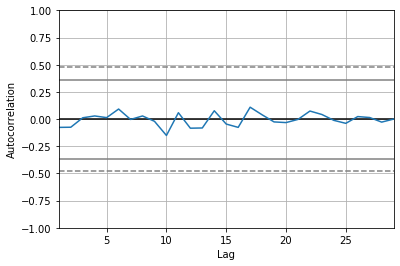

In [191]:
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
autocorrelation_plot(DLdataset6)
pyplot.show()

In [328]:
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [334]:
DLdataset6.to_csv (r'C:\Users\muanwer\DiffLogEcon10.csv', index = True, header=True)

In [336]:
#Import the CSV file with annual data on variables from 1990

DLdataset6a = pd.read_csv("DiffLogEcon102020.csv", parse_dates=['date'], index_col='date')

In [337]:
DLdataset6a.tail(5)

KSAGDPC    CRISIS      MANU    CONCOF      WGDP   GUNCERT  \
date                                                                     
2016-12-31 -0.014364 -0.405465  0.031403  0.000338  0.013923  0.086230   
2017-12-31  0.065464  0.000000  0.012860  0.002228  0.020020 -0.127608   
2018-12-31  0.132932  0.000000  0.020683  0.000454  0.019041  0.035379   
2019-12-31  0.008158  0.000000  0.016108 -0.006123  0.028585  0.543390   
2020-12-31 -0.116000 -0.405465 -0.037000 -0.006000 -0.013000  0.369000   

            WTIPrice    IMPORT    EXPORT  GovConsExDef  GFIXEDCAP     Oggva  
date                                                                         
2016-12-31 -0.114441 -0.249067 -0.081190     -0.146430  -0.146891  0.028211  
2017-12-31  0.156631  0.020001  0.177334      0.009855   0.000000 -0.037077  
2018-12-31  0.245743  0.038840  0.268754      0.137428  -0.030524  0.035973  
2019-12-31 -0.132863 -0.014389 -0.125375     -0.035627   0.058607 -0.044917  
2020-12-31 -0.649061 -0.154589 -0.649788     -0.650000  -0.112308 -0.650000

<h4> Model 2  - Ordinary Least Squares <h/4>

In [338]:
# Putting feature variable to X
X = DLdataset6a[['MANU', 'CONCOF', 'WGDP', 'GUNCERT', 'WTIPrice', 'IMPORT', 'EXPORT', 'GovConsExDef', 'GFIXEDCAP']]

# Putting response variable to y
y = DLdataset6a['KSAGDPC']


In [339]:
import statsmodels.api as sm
#Unlike SKLearn, statsmodels don't automatically fit a constant, 
#so we need to use the method sm.add_constant(X) in order to add a constant. 
X = sm.add_constant(X)
# create a fitted model in one line (no need of defining a function as this is pretty short code)
lm_1 = sm.OLS(y,X).fit()
print(lm_1.summary())

#The regression below has Durban Watson statistic close to 2, indicating low autocorrelation

                            OLS Regression Results                            
Dep. Variable:                KSAGDPC   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     32.08
Date:                Tue, 19 May 2020   Prob (F-statistic):           5.76e-10
Time:                        21:28:02   Log-Likelihood:                 64.703
No. Observations:                  30   AIC:                            -109.4
Df Residuals:                      20   BIC:                            -95.39
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0237      0.014      1.750   

In [341]:
#Calculating the residuals

pred_val = lm_1.fittedvalues.copy()
true_val = DLdataset6a['KSAGDPC'].values.copy()
residual = true_val - pred_val

0.9890272349263965

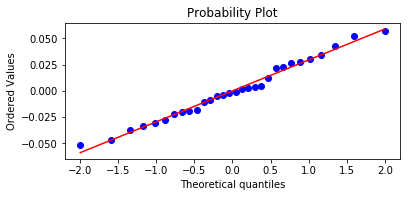

In [342]:
#We can plot a normal probability plot to assess how the data (error) departs from normality visually:

import scipy as sp
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
r**2

#Normality is not looking that bad. Seems like there are very strong underlying non linear trends that are out of scope for OLS
#Regression to capture. I still see very heavy outliers.

In [490]:
#random_state is the seed used by the random number generator, it can be any integer.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9 ,test_size = 0.1, random_state=5)

In [491]:
import statsmodels.api as sm          # Importing statsmodels
X_train = sm.add_constant(X_train)    # Adding a constant column to our dataframe
# create a first fitted model
Nlm_1 = sm.OLS(y_train,X_train).fit()

In [492]:
print(Nlm_1.summary())


                            OLS Regression Results                            
Dep. Variable:                KSAGDPC   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     44.80
Date:                Tue, 19 May 2020   Prob (F-statistic):           4.38e-10
Time:                        21:39:58   Log-Likelihood:                 64.593
No. Observations:                  27   AIC:                            -109.2
Df Residuals:                      17   BIC:                            -96.23
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0073      0.013      0.581   

In [493]:
# Making predictions for order
y_pred = Nlm_1.predict(X_test)

In [494]:
y_test

date
2002-12-31    0.029224
2020-12-31   -0.116000
2014-12-31    0.012907
Name: KSAGDPC, dtype: float64

In [495]:
y_pred

date
2002-12-31    0.051489
2020-12-31   -0.293780
2014-12-31   -0.006280
dtype: float64

Text(0, 0.5, 'date')

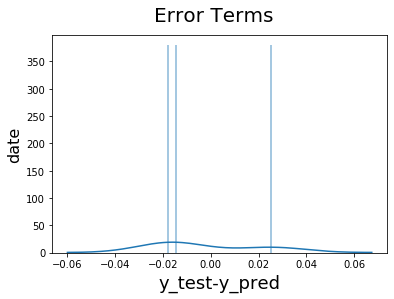

In [318]:
# Plotting the error terms to understand the distribution.Not exactly normal. Full of head and tail events, and skewed.
fig = plt.figure()
sns.distplot((y_test-y_pred),bins=50)
fig.suptitle('Error Terms', fontsize=20)                  # Plot heading 
plt.xlabel('y_test-y_pred', fontsize=18)                  # X-label
plt.ylabel('date', fontsize=16)                          # Y-label

In [319]:
y_train

date
1997-12-31    0.044916
2002-12-31    0.029224
2007-12-31    0.099220
2015-12-31   -0.144930
2018-12-31    0.132932
2001-12-31   -0.028744
2004-12-31    0.181240
2003-12-31    0.129269
2008-12-31    0.223376
1994-12-31    0.016429
2016-12-31   -0.014364
2011-12-31    0.239529
1999-12-31    0.096776
2012-12-31    0.092036
1998-12-31   -0.121322
2006-12-31    0.136902
1991-12-31    0.116696
1992-12-31    0.036059
2014-12-31    0.012907
1995-12-31    0.058559
1993-12-31   -0.030454
1996-12-31    0.101359
2019-12-31    0.008158
2010-12-31    0.207687
2000-12-31    0.158379
2013-12-31    0.014392
Name: KSAGDPC, dtype: float64